In [1]:
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from pathlib import Path

# from numba import jit
import numpy as np
import pandas as pd

%config Completer.use_jedi = False

# # required to enable non-blocking interaction:
%gui qt5

import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to plot Speed vs. Pf Desnity Metrics
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtCore, QtGui
import pyphoplacecellanalysis.External.pyqtgraph.opengl as gl # for 3D raster plot

# Pho's Formatting Preferences
from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences()
# np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))
# np.set_printoptions(edgeitems=None, linewidth=100000, formatter=None)
set_pho_preferences_concise()

# For Progress bars:
# from tqdm.notebook import tqdm, trange

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import get_arguments_as_optional_dict, inspect_callable_arguments
from pyphocorehelpers.indexing_helpers import partition, build_spanning_bins, compute_spanning_bins, compute_position_grid_size, compute_paginated_grid_config
from pyphocorehelpers.print_helpers import PrettyPrintable, WrappingMessagePrinter, print_keys_if_possible, debug_dump_object_member_shapes
from pyphocorehelpers.DataStructure.dynamic_parameters import DynamicParameters
from pyphocorehelpers.performance_timing_helpers import WrappingPerformanceTimer
from pyphocorehelpers.gui.interaction_helpers import CallbackWrapper

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
# from pyphoplacecellanalysis.General.SessionSelectionAndFiltering import batch_filter_session, build_custom_epochs_filters
from neuropy.core.session.KnownDataSessionTypeProperties import KnownDataSessionTypeProperties

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DisplayFunctionRegistryHolder import DisplayFunctionRegistryHolder

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.placefields import PlacefieldComputationParameters

from neuropy.core.laps import Laps  # Used for adding laps in KDiba mode
from neuropy.utils.efficient_interval_search import get_non_overlapping_epochs, drop_overlapping # Used for adding laps in KDiba mode

from neuropy.core.epoch import NamedTimerange

from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder, DataSessionFormatBaseRegisteredClass
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat


known_data_session_type_properties_dict = DataSessionFormatRegistryHolder.get_registry_known_data_session_type_dict()
active_data_session_types_registered_classes_dict = DataSessionFormatRegistryHolder.get_registry_data_session_type_class_name_dict()
# DataSessionFormatRegistryHolder.get_registry()

enable_saving_to_disk = False
# common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\Final Placemaps 2021-01-14')
common_parent_foldername = Path(r'R:\Dropbox (Personal)\Active\Kamran Diba Lib\Pho-Kamran-Meetings\2022-01-16')


def JupyterLab_excepthook(exc_type, exc_value, exc_tb):
    tb = "".join(traceback.format_exception(exc_type, exc_value, exc_tb))
    print("JupyterLab_excepthook error catched!:")
    print("\t error message:\n", tb)
    QtWidgets.QApplication.quit()
    # or QtWidgets.QApplication.exit(0)
    
sys.excepthook = JupyterLab_excepthook

## Concise Numpy Array Printing:
np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# np.set_string_function(None, repr=True)

# Loading Tests:

In [ ]:
# print(known_data_session_type_dict['kdiba'].__init__.__code__)
known_data_session_type_dict

In [ ]:
# KnownDataSessionTypeProperties
# from neuropy.core.
known_data_session_type_dict['kdiba'] # KnownDataSessionTypeProperties

known_data_session_type_dict['kdiba'].basedir
known_data_session_type_dict['kdiba'].basedir = 

In [ ]:
# _session_default_relative_basedir = r'data/KDIBA/gor01/one/2006-6-07_11-26-53'
relative_path = Path(KDibaOldDataSessionFormatRegisteredClass._session_default_relative_basedir)

In [ ]:
root_path =  Path(r'R:/') # Windows
root_path =  Path(r'/run/media/halechr/MoverNew') # Linux/Lab
root_path

In [ ]:
final_path = root_path.joinpath(relative_path)    
final_path

final_path.exists() # .exists()

In [ ]:
final_path.anchor # '\\'
final_path.drive # ''
potentially_viable_parents = list(final_path.parents)
potentially_viable_parents

In [ ]:
## Test Finding the highest replacement path that should exist:

def _find_highest_extant_path(final_path):
    if final_path.exists():
        return final_path
    else:        
        potentially_viable_parents = list(final_path.parents)
        potentially_viable_parents
        # [WindowsPath('/run/media/halechr/MoverNew/data/KDIBA/gor01/one'),
        #  WindowsPath('/run/media/halechr/MoverNew/data/KDIBA/gor01'),
        #  WindowsPath('/run/media/halechr/MoverNew/data/KDIBA'),
        #  WindowsPath('/run/media/halechr/MoverNew/data'),
        #  WindowsPath('/run/media/halechr/MoverNew'),
        #  WindowsPath('/run/media/halechr'),
        #  WindowsPath('/run/media'),
        #  WindowsPath('/run'),
        #  WindowsPath('/')]
        for a_parent_path in potentially_viable_parents:
            if a_parent_path.exists():
                return a_parent_path # stop and return the parent path that exists
            
        return None # No Path matches, require a complete change of root (this would be expected going form Linux to Windows
    
    
found_final_path = _find_highest_extant_path(final_path)
found_final_path

## Bapun Format:

In [7]:
active_data_mode_name = 'bapun'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
curr_bapun_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties)
curr_active_pipeline = curr_bapun_pipeline
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

basedir is already Path object.
converting neuron_type strings to core.neurons.NeuronType objects...
	 done.
Position falling back to legacy loading protocol...: dict_rep: {'traces': np.array[(3, 2538347)], 'computed_traces': np.array[(1, 2538347)], 't_start': 0, 'sampling_rate': 60, 'metadata': None}


c:\users\pho\repos\neuropy\neuropy\core\session\Formats\SessionSpecifications.py:139: UserWarning: WARNING: Optional File: R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.dat does not exist. Continuing without it.
  warnings.warn(f'WARNING: Optional File: {an_optional_filepath} does not exist. Continuing without it.')


linearized position loaded from file.
Loading success: .flattened.spikes.npy.
Loading success: .ripple.npy.
Loading success: .mua.npy.
Loading success: .pbe.npy.
Computing spikes_df PBEs column results to spikes_df... done.
Computing added spike scISI column results to spikes_df... done.


In [14]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0], omitted_computation_functions_name_list=['_perform_spike_burst_detection_computation']) # SpikeAnalysisComputations._perform_spike_burst_detection_computation
curr_active_pipeline.prepare_for_display(should_smooth_maze=False) # TODO: pass a display config

## Rachel Format:

In [ ]:
active_data_mode_name = 'rachel'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]
curr_rachel_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties)
curr_active_pipeline = curr_rachel_pipeline
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

In [ ]:
curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

## KDiba Format:

In [ ]:
active_data_mode_name = 'kdiba'
active_data_mode_registered_class = active_data_session_types_registered_classes_dict[active_data_mode_name]
active_data_mode_type_properties = known_data_session_type_properties_dict[active_data_mode_name]

## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m
# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'
# # ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'
# curr_kdiba_pipeline = NeuropyPipeline(name='kdiba_pipeline', session_data_type='kdiba', basedir=known_data_session_type_dict['kdiba'].basedir, load_function=known_data_session_type_dict['kdiba'].load_function)
curr_kdiba_pipeline = NeuropyPipeline.init_from_known_data_session_type(active_data_mode_name, active_data_mode_type_properties, override_basepath=Path(basedir))
curr_active_pipeline = curr_kdiba_pipeline
active_session_filter_configurations = active_data_mode_registered_class.build_default_filter_functions(sess=curr_active_pipeline.sess) # build_filters_pyramidal_epochs(sess=curr_kdiba_pipeline.sess)
active_session_computation_configs = active_data_mode_registered_class.build_default_computation_configs(sess=curr_active_pipeline.sess)

curr_active_pipeline.filter_sessions(active_session_filter_configurations)
curr_active_pipeline.perform_computations(active_session_computation_configs[0]) # Causes "IndexError: index 59 is out of bounds for axis 0 with size 59"
curr_active_pipeline.prepare_for_display(should_smooth_maze=True) # TODO: pass a display config

# Common: Computations
Common analyses/computation functions for both forms of data/pipelines:

In [ ]:
from pyphocorehelpers.indexing_helpers import nested_dicts_to_flatpaths, flatpaths_to_nested_dicts

In [ ]:
_disable_dict = {} # empty dict by default
_disable_dict['SpikeAnalysisComputations'] = False # disables all members of SpikeAnalysisComputations
_disable_dict['ExtendedStatsComputations'] = {'_perform_placefield_overlap_computation': False} # Disables only the '_perform_placefield_overlap_computation' function of 'ExtendedStatsComputations'
_disable_dict

In [ ]:
_curr_fcn = backup_temp_compuitations_functions_list['SpikeAnalysisComputations']['_perform_spike_burst_detection_computation']
_curr_fcn.pho_test_property = False

In [ ]:
backup_temp_compuitations_functions_list['SpikeAnalysisComputations']['_perform_spike_burst_detection_computation'].pho_is_enabled_property = False


In [ ]:
backup_temp_compuitations_functions_list['SpikeAnalysisComputations']['_perform_spike_burst_detection_computation'].pho_is_enabled_property

# Common: Display
Common visualization and display functions for both forms of data/pipelines:

In [15]:
active_config_name = 'maze1'
# active_config_name = 'maze2'
# active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
print(f'active_computed_data.keys(): {active_computed_data.keys()}')
# print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']    
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

display_output = dict()

active_computed_data.keys(): dict_keys(['pf1D', 'pf2D', 'pf1D_dt', 'pf2D_dt', 'pf2D_Decoder', 'pf2D_TwoStepDecoder', 'EloyAnalysis', 'extended_stats', 'firing_rate_trends', 'placefield_overlap'])


In [16]:
active_computation_errors.keys()

dict_keys([])

([<Figure size 9216x864 with 91 Axes>],
 [<mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x1c4824f8340>])

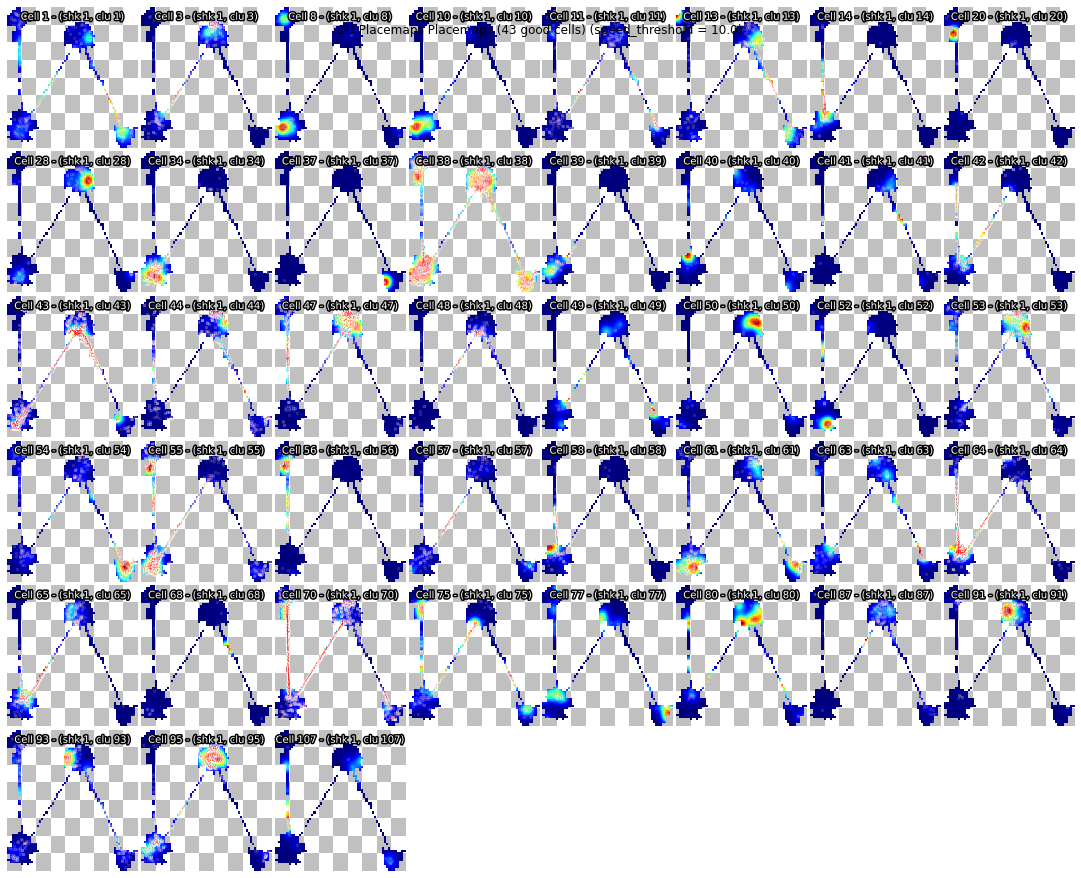

In [17]:
active_pf_2D.plot_ratemaps_2D()

## Call non-occupancy normalized version 'SpikeMap'

In [ ]:
def _build_cell_color_map(curr_active_displa+y_config, debug_print=False):
    """ builds a list of pg.mkColors from the cell index id:     
    """
    pf_neuron_identities = curr_active_display_config.pf_neuron_identities
    pf_colors = curr_active_display_config.pf_colors.copy()
    
    n_cells = len(pf_neuron_identities)
    
    provided_neuron_id_to_color_map = {}
    for idx in np.arange(n_cells):
        curr_neuron_identity = pf_neuron_identities[idx]
        curr_color = np.squeeze(pf_colors[:, idx])
        print(f'idx: {idx}: curr_color: {curr_color}')
        # curr_qcolor = pg.mkColor(tuple(curr_color)) # make a QColor
        curr_qcolor = QtGui.QColor(curr_color) # make a QColor
        provided_neuron_id_to_color_map[curr_neuron_identity.cell_uid] = curr_qcolor
        
    return provided_neuron_id_to_color_map

provided_neuron_id_to_color_map = _build_cell_color_map(curr_active_display_config)
provided_neuron_id_to_color_map

In [ ]:
## Find missing neuron_ids from curr_spikes_df and add them to the provided_neuron_id_to_color_map as the default fallback color (black):
all_neuron_ids = np.unique(curr_spikes_df.aclu)
all_neuron_ids

missing_color_indicies = np.isin(all_neuron_ids, list(provided_neuron_id_to_color_map.keys()), assume_unique=True, invert=True)
missing_color_neuron_ids = all_neuron_ids[missing_color_indicies]
missing_color_neuron_ids # array([23])

# Add the missing neuron_ids to the color array:
fallback_color_rgba = pg.mkColor(0, 0, 0, 1.0)
for a_missing_neuron_id in missing_color_neuron_ids:
    print(f'added neuron_id {a_missing_neuron_id} to the colors array.')
    provided_neuron_id_to_color_map[a_missing_neuron_id] = fallback_color_rgba

In [ ]:
provided_neuron_id_to_color_map

In [ ]:
# provided_neuron_id_to_color_map[2].name()
curr_color = provided_neuron_id_to_color_map[2]
curr_color.getRgb()
curr_color.getRgbF()
# provided_neuron_id_to_color_map[2].name(QtGui.QColor.HexRgb)

##  Top-Level Window/Widget/Plot Enumeration:

In [ ]:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper

app = pg.mkQApp()
# app = pg.mkQApp(spike_raster_window.applicationName) # <PyQt5.QtWidgets.QApplication at 0x1d44a4891f0>
app

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.SpikeRasterBase import SpikeRasterBase
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster

In [ ]:
TopLevelWindowHelper.top_level_windows(app) # IndexedOrderedDict([('RootWidgetWindow', <PyQt5.QtGui.QWindow object at 0x00000271A482E8B0>)])

In [ ]:
TopLevelWindowHelper.all_widgets(app)

In [ ]:
# All widgets
all_widgets_list = app.allWidgets()
all_widgets_list_is_spike_raster = [isinstance(a_widget, (SpikeRasterBase)) for a_widget in all_widgets_list]
# Only widgets that inherit from SpikeRasterBase
all_spike_raster_widgets_list = [a_widget for a_widget in all_widgets_list if isinstance(a_widget, (SpikeRasterBase))]
all_spike_raster_widgets_list

In [ ]:
# Iterate through to update the plots objects
for a_plot_widget in all_spike_raster_widgets_list:
    print(list(a_plot_widget.plots.keys()))
    

In [ ]:
# All windows: returns a list of QWindow objects, may be more than are active:
top_level_windows = app.allWindows()
top_level_window_names = [a_window.objectName() for a_window in top_level_windows] #['Spike3DRaster_VedoClassWindow', 'QFrameClassWindow', 'QWidgetClassWindow', 'PhoBaseMainWindowClassWindow']
top_level_window_is_visible = [a_window.isVisible() for a_window in top_level_windows] 

In [ ]:
# top_level_windows[0].objectName()
top_level_window_names #['Spike3DRaster_VedoClassWindow', 'QFrameClassWindow', 'QWidgetClassWindow', 'PhoBaseMainWindowClassWindow']
top_level_window_is_visible

In [ ]:
## Enumerate plot items by looking at items in main_gl_widget (which is a GLViewWidget): 
root_gl_view_widget = spike_raster_window.spike_raster_plt_3d.ui.main_gl_widget # GLViewWidget 
root_gl_view_widget_items_list = root_gl_view_widget.items
root_gl_view_widget_item_names = [an_item.objectName() for an_item in root_gl_view_widget_items_list]
root_gl_view_widget_item_names

# Note that these GLGraphicsItem subclasses have: .visible(), .setVisible(is_visable), .parentItem(), .setParentItem(parent_item), .childItems(), .transform(), .viewTransform()

In [ ]:

# type(spike_raster_window.spike_raster_plt_2d)

children = app.findChildren(Spike3DRaster)
print(children)
# for child in children:
#     print(child.objectName())

print(spike_raster_window.objectName())
spike_raster_window.spike_raster_plt_2d.objectName()

spike_raster_window.spike_raster_plt_2d.windowName # 'Spike2DRaster'
spike_raster_window.spike_raster_plt_3d.windowName # 'Spike3DRaster'
spike_raster_window.windowName # 'Spike3DRasterWindow'

In [ ]:
children = app.findChildren(Spike3DRaster)
print(children)

## 3D Interactive Spike Raster Window

In [18]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

display_output = display_output | curr_active_pipeline.display('_display_spike_rasters_window', active_config_name, active_config_name=active_config_name)
spike_raster_window = display_output['spike_raster_window']
# spike_raster_plt_2d = display_output['spike_raster_plt_2d']
# spike_raster_plt_3d = display_output['spike_raster_plt_3d']

Spike2DRaster.setup(): adding "visualization_raster_y_location" column to spikes_df...
done.


In [ ]:
display_output

DisplayFunctionRegistryHolder
# spike_raster_window.show()

In [ ]:
spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=curr_active_display_config.pf_colors.copy(), neuron_sort_order=None, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=provided_neuron_id_to_color_map, neuron_sort_order=None, application_name=f'Spike Raster Window - {active_config_name}')
# spike_raster_window = Spike3DRasterWindowWidget(curr_spikes_df, neuron_colors=ipcDataExplorer.active_neuron_render_configs_map) # Test passing in an existing render configs map
# Set Window Title Options:
spike_raster_window.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window.setWindowTitle(f'Spike Raster Window - {active_config_name} - {str(sess.filePrefix.resolve())}')

In [ ]:
spike_raster_window.spike_raster_plt_2d.cell_id_to_fragile_linear_neuron_IDX_map

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=provided_neuron_id_to_color_map)

In [ ]:
# Setup Connections Menu:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(spike_raster_window) # none of these properties need to be 

### Test building a second spike_raster_window for a different epoch:

In [ ]:
secondary_active_config_name = 'maze2'
secondary_spikes_df = curr_active_pipeline.filtered_sessions[secondary_active_config_name].spikes_df
spike_raster_window_second_epoch = Spike3DRasterWindowWidget(secondary_spikes_df, application_name=f'Spike Raster Window - {secondary_active_config_name}', type_of_3d_plotter='vedo')
# Set Window Title Options:
spike_raster_window_second_epoch.setWindowFilePath(str(sess.filePrefix.resolve()))
spike_raster_window_second_epoch.setWindowTitle(f'Spike Raster Window - {secondary_active_config_name} - {str(sess.filePrefix.resolve())}')
spike_raster_window_second_epoch

In [ ]:
spike_raster_window.spikes_df # has scISI column!


In [ ]:
spike_raster_window.connection_man

In [ ]:
spike_raster_window.connection_man.active_connections

In [ ]:
spike_raster_window.connection_man.get_available_drivers()

## ipcDataExplorer - 3D Interactive Tuning Curves Plotter

In [19]:
pActiveTuningCurvesPlotter = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None), panel_controls_mode='Qt') # Works now!
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode:

to_dict(...): ['_save_intermediate_firing_maps', 'config', 'position_srate', 'ndim', '_included_thresh_neurons_indx', '_peak_frate_filter_function', 'ratemap', 'ratemap_spiketrains', 'ratemap_spiketrains_pos', '_filtered_pos_df', '_filtered_spikes_df', 'xbin', 'ybin', 'bin_info']
[ 7  9 17 23 27 60 62 78 79] are not present in for the placefields. A map (self.params.reverse_cellID_to_tuning_curve_idx_lookup_map) will be built.
	 computed included_cell_INDEXES.
	 set self._obj['fragile_linear_neuron_IDX']
	 set self._obj['neuron_IDX']
	 done updating 'fragile_linear_neuron_IDX' and 'neuron_IDX'.
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter
_temp_input_params: {}
self.params.debug_disable_all_gui_controls is True, so no gui controls will be built.
update_active_spikes(spike_opacity_mask: ..., is_additive: True)
change_unit_spikes_included(...):
	neuron_IDXs: [20]
	extracted_cell_ids:[42]
	config_IDXs:[15]
Found a group with the identif

In [ ]:
## Set the colors of the raster window from the tuning curve window:
spike_raster_window.update_neurons_color_data(updated_neuron_render_configs=ipcDataExplorer.active_neuron_render_configs_map)

## ipspikesDataExplorer - 3D Interactive Spike and Behavior Plotter

In [20]:
pActiveSpikesBehaviorPlotter = None
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name, extant_plotter=display_output.get('pActiveSpikesBehaviorPlotter', None)) # Works now!
ipspikesDataExplorer = display_output['ipspikesDataExplorer']
display_output['pActiveSpikesBehaviorPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveSpikesBehaviorPlotter = display_output['pActiveSpikesBehaviorPlotter']

computation_result.sess: DataSession(RatS-Day5TwoNovel-2020-12-04_07-55-09.xml)
active_epoch_pos.sampling_rate (Hz): 59.999976362569846
longer_spikes_window - curr_view_window_length_samples - 61439
recent_spikes_window - curr_view_window_length_samples - 599
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter
[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D
removed object with key CellSpikePositionDataExplorer from drivable list.


In [ ]:
## Sync ipspikesDataExplorer to raster window:
extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

### Test Programmatic Updating of the ipspikesDataExplorer

In [ ]:
ipspikesDataExplorer.spikes_main_historical.VisibilityOff()
# ipspikesDataExplorer.

In [ ]:
np.shape(ipspikesDataExplorer.params.flattened_spike_positions_list) # (2, 102139)
np.shape(ipspikesDataExplorer.flattened_spike_times) # (102139,)

recent_spikes_mesh = ipspikesDataExplorer.plots['spikes_main_recent_only']
# ipspikesDataExplorer.plots.keys() # dict_keys(['spikes_main_historical', 'spikes_main_recent_only', 'animal_location_trail', 'animal_current_location_point', 'maze_bg'])
# , show_edges=True

In [ ]:
ipspikesDataExplorer.spikes_main_historical.AddPosition((0.0, 0.0, (-1.1*10)))

## Test GlobalConnectionManager

In [ ]:
from pyphocorehelpers.gui.Qt.GlobalConnectionManager import GlobalConnectionManager
# app = pg.mkQApp()
# connection_man = GlobalConnectionManager(owning_application=app)
connection_man = spike_raster_window.connection_man
connection_man

In [ ]:
connection_man.registered_available_drivers

In [ ]:
connection_man.registered_available_drivables

In [ ]:
# connection_man
connection_man.active_connections

# unregister_object

In [ ]:
list(connection_man.active_connections.keys())
list(connection_man.registered_available_drivables.keys())
list(connection_man.registered_available_drivers.keys())

In [ ]:
connection_man.register_driver(driver=spike_raster_window.spike_raster_plt_2d)
# connection_man.reg

In [ ]:
ipspikesDataExplorer.data_explorer_name

In [ ]:
connection_man.register_drivable(ipspikesDataExplorer, ipspikesDataExplorer.data_explorer_name) # ipspikesDataExplorer.data_explorer_name: 'CellSpikePositionDataExplorer'
connection_man.register_drivable(spike_raster_window.spike_raster_plt_3d)
connection_man.register_drivable(spike_raster_window.spike_raster_plt_2d)

In [ ]:
connection_man.unregister_object(spike_raster_window.spike_raster_plt_2d)
# GlobalConnectionManager._unregister_object(connection_man.registered_available_drivables, control_object=spike_raster_window.spike_raster_plt_2d)

In [ ]:
ipspikesDataExplorer.connection_man

In [ ]:
extra_interactive_spike_behavior_browser_sync_connection = connection_man.connect_drivable_to_driver(drivable=ipspikesDataExplorer, driver=spike_raster_window.spike_raster_plt_2d)

In [ ]:
## Sync ipspikesDataExplorer to raster window:
# extra_interactive_spike_behavior_browser_sync_connection = spike_raster_window.connect_additional_controlled_plotter(controlled_plt=ipspikesDataExplorer)
# extra_interactive_spike_behavior_browser_sync_connection = _connect_additional_controlled_plotter(spike_raster_window.spike_raster_plt_2d, ipspikesDataExplorer)

In [ ]:
## Test Getting the active connection for this object:
# found_connection = connection_man.active_connections.get(ipspikesDataExplorer, None) # <PyQt5.QtCore.QMetaObject.Connection at 0x26ed46964a0>
# # found_connection
# if found_connection is not None:
#     print(f'found_connection: {found_connection}, disconnecting...')
#     spike_raster_window.spike_raster_plt_2d.disconnect(found_connection)
#     print(f'\t done.')
#     del connection_man.active_connections[ipspikesDataExplorer]
#     ipspikesDataExplorer.enable_ui_window_updating_controls() # disable the GUI for manual updates.
#     # self.disconnect(found_connection)
#     print(f'\t removed!')
# else:
#     print(f'connection not found!')

def 
found_connection = connection_man.active_connections.get(ipspikesDataExplorer, None) # <PyQt5.QtCore.QMetaObject.Connection at 0x26ed46964a0>
# found_connection
if found_connection is not None:
    print(f'found_connection: {found_connection}, disconnecting...')
    spike_raster_window.spike_raster_plt_2d.disconnect(found_connection)
    print(f'\t done.')
    del connection_man.active_connections[ipspikesDataExplorer]
    ipspikesDataExplorer.enable_ui_window_updating_controls() # disable the GUI for manual updates.
    # self.disconnect(found_connection)
    print(f'\t removed!')
else:
    print(f'connection not found!')

In [ ]:
ipspikesDataExplorer.disable_ui_window_updating_controls() # enable_ui_window_updating_controls() # disable the GUI for manual updates.

## Test Adding Dynamic Menus and Status bars:

In [ ]:
# ipspikesDataExplorer.p.app_window # <pyvistaqt.window.a_main_window at 0x16148c1e160>
curr_window = ipspikesDataExplorer.p.app_window
menubar = curr_window.menuBar()
# root_children = menubar.children()
root_children = [a_child for a_child in menubar.children() if isinstance(a_child, pg.QtWidgets.QMenu)] # .title
root_children
# QMenu
# fileMenu = menubar.addMenu('&File')
# [a_child.objectName() for a_child in menubar.children()] # .title

[a_child.title() for a_child in root_children] # .title ['File', 'View', 'Tools', '', '&File']
# QToolButton

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Mixins.Menus.ConnectionControlsMenuMixin import ConnectionControlsMenuMixin
curr_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(spike_raster_window)

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Mixins.Menus.CreateNewConnectedWidgetMenuMixin import CreateNewConnectedWidgetMenuMixin
curr_window, menuCreateNewConnected, actions_dict = CreateNewConnectedWidgetMenuMixin.try_add_create_new_connected_widget_menu(spike_raster_window, curr_active_pipeline, active_config_name, display_output)

In [ ]:
CreateNewConnectedWidgetMenuMixin.try_remove_create_new_connected_widget_menu(a_content_widget=spike_raster_window)

In [ ]:
curr_window.ui.menubar

In [ ]:
curr_window.menuBar()

In [ ]:
found_extant_menu = curr_window.ui.menubar.findChild(QtWidgets.QMenu, "menuCreateNewConnectedWidget") #"menuCreateNewConnectedWidget"
found_extant_menu

In [ ]:
found_extant_menu.isVisible()

In [ ]:
found_extant_menu.isEmpty()

In [ ]:
found_extant_menu.isEnabled()

In [ ]:
found_extant_menu.children()
# found_extant_menu.removeAction()
found_extant_menu.clear()

In [ ]:
curr_window.ui.menubar.clear()
curr_window.ui.menubar.removeAction(curr_window.ui.actionMenuCreateNewConnectedWidget)

In [ ]:
curr_window.ui.menubar.clear()

In [ ]:
curr_window.ui.menubar.clear()

In [ ]:
def _test_connect_child():
    """ Implicitly captures ipspikesDataExplorer """
    found_child_drivables = ipspikesDataExplorer.connection_man.get_available_drivables() # get the list of drivable children
    print(f'found_child_drivables: {found_child_drivables}')
    extra_interactive_spike_behavior_browser_sync_connection = connection_man.connect_drivable_to_driver(drivable=ipspikesDataExplorer, driver=spike_raster_window.spike_raster_plt_2d)
    
def _test_disconnect_child():
    
    
ipspikesDataExplorer.p.app_window.ui.actionConnect_Child.triggered.connect(_test_connect_child)

In [ ]:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(ipspikesDataExplorer.p.app_window) # none of these properties need to be saved directly, as they're accessible via ipspikesDataExplorer.p.app_window.window()

In [ ]:
ConnectionControlsMenuMixin.try_remove_connections_menu(spike_raster_window)

### Test Adding Dynamic Menu for "Create New connected...":

In [ ]:
# class MenuItemDefn(object):
from qtpy import QtCore, QtGui, QtWidgets
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.MainWindowWrapper import PhoBaseMainWindow
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons
from pyphoplacecellanalysis.GUI.Qt.Mixins.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.General.Mixins.StylesheetThemingHelpers import StylesheetThemingHelpers
from pyphoplacecellanalysis.GUI.Qt.Mixins.Menus.DebugMenuProviderMixin import DebugMenuProviderMixin
mainWindow = PhoMenuHelper.try_get_menu_window(spike_raster_window)
menubar = PhoMenuHelper.try_get_menu_bar(spike_raster_window)
PhoMenuHelper.set_menu_default_stylesheet(menubar) # Sets the default menu stylesheet

In [ ]:
# mainWindow # PhoBaseMainWindow 
spike_raster_window.window() # PhoBaseMainWindow
# spike_raster_window.window() = None
# spike_raster_window.windowName
# mainWindow = None

In [ ]:
spike_raster_window.windowHandle() # <PyQt5.QtGui.QWindow at 0x150301f5040>
spike_raster_window.window() # <pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget.Spike3DRasterWindowWidget at 0x1502d5df700>

# spike_raster_window.setParent()

In [ ]:
mainWindow.windowType()

#### Build New Test Menu:

In [ ]:
DebugMenuProviderMixin

In [ ]:
# Define dictionary:
mainWindow.ui.menuDebugActionsDict = {}
an_action_key, active_debug_menu = PhoMenuHelper.add_menu(a_main_window=mainWindow, text="Debug", name='actionMenuDebug', parent_menu=menubar, menu_actions_dict=mainWindow.ui.menuDebugActionsDict)
an_action_key # 'actionMenuDebug'

In [ ]:
# active_debug_menu = mainWindow.ui['actionMenuDebug']
# active_debug_menu
active_debug_menu

In [ ]:
mainWindow.ui.menuDebugActionsDict

In [ ]:
an_action_key, active_drivers_menu = PhoMenuHelper.add_menu(a_main_window=mainWindow, text="Active Drivers", name='actionMenuDebugMenuActiveDrivers', parent_menu=active_debug_menu, menu_actions_dict=mainWindow.ui.menuDebugActionsDict)
# active_drivers_menu = mainWindow.ui['actionMenuDebugMenuActiveDrivers']
an_action_key, active_drivables_menu = PhoMenuHelper.add_menu(a_main_window=mainWindow, text="Active Drivables", name='actionMenuDebugMenuActiveDrivables', parent_menu=active_debug_menu, menu_actions_dict=mainWindow.ui.menuDebugActionsDict)
# active_drivables_menu = mainWindow.ui['actionMenuDebugMenuActiveDrivables']
an_action_key, active_connections_menu = PhoMenuHelper.add_menu(a_main_window=mainWindow, text="Active Connections", name='actionMenuDebugMenuActiveConnections', parent_menu=active_debug_menu, menu_actions_dict=mainWindow.ui.menuDebugActionsDict)
# active_connections_menu = mainWindow.ui['actionMenuDebugMenuActiveConnections']

In [ ]:
# Adding a separator
# fileMenu.addSeparator()


## Add the dynamic menu entries:





# menu = QtWidgets.QMenu()
# menu.addAction("red")
# menu.addAction("green")
# menu.addAction("blue")
# colorButton.setMenu(menu)

# menu.triggered.connect(lambda action: print(action.text()))

active_drivers_menu.addActions()

In [ ]:
## Update Drivers Menu:
curr_drivers_items = list(connection_man.registered_available_drivers.keys())
for a_driver_key in curr_drivers_items:
    active_drivers_menu.addAction(a_driver_key)
# active_drivers_menu.triggered.connect(lambda action: print(action.text()))
active_drivers_menu.triggered.connect(lambda action: print(connection_man.registered_available_drivers.get(action.text(), f'Driver KeyNotFound: {action.text()}')))

In [ ]:
## Update Drivable Menu:
curr_drivable_items = list(connection_man.registered_available_drivables.keys())
for a_driveable_key in curr_drivable_items:
    active_drivables_menu.addAction(a_driveable_key)
active_drivables_menu.triggered.connect(lambda action: print(connection_man.registered_available_drivables.get(action.text(), f'Drivable KeyNotFound: {action.text()}')))

In [ ]:
curr_connections_items = list(connection_man.active_connections.keys())
curr_connection_item = connection_man.active_connections.items()[0] # (<pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster.Spike3DRaster at 0x230d539ddc0>, <pyphoplacecellanalysis.External.pyqtgraph.SignalProxy.SignalProxy at 0x230e7c86430>)
# curr_connection_item[0]
curr_connection_value = curr_connection_item[1] # <pyphoplacecellanalysis.External.pyqtgraph.SignalProxy.SignalProxy at 0x230e7c86430>
# curr_connection_value.dumpObjectTree()
# curr_connection_value.dumpObjectInfo()
# curr_connection_value.sender()
# curr_connection_value.slot
curr_connection_value.signal # <bound PYQT_SIGNAL window_scrolled of Spike2DRaster object at 0x00000230D5384DC0>
# curr_connection_value.signal.signal


In [ ]:
## Update Connections Menu:
curr_connections_items = list(connection_man.active_connections.keys())
for a_connection_key in curr_connections_items:
    active_connections_menu.addAction(a_connection_key)
active_connections_menu.triggered.connect(lambda action: print(connection_man.active_connections.get(action.text(), f'Connection KeyNotFound: {action.text()}')))

In [ ]:
# menubar.children()
# active_debug_menu.findChild(QtWidgets.QMenu, name="actionMenuDebugMenuActiveDrivers")
# active_debug_menu.findChild("actionMenuDebugMenuActiveDrivers")
active_debug_menu.findChild(QtWidgets.QMenu)
active_debug_menu.children()
# menubar.findChild("actionMenuDebugMenuActiveDrivers")
# actionMenuDebugMenuActiveConnections

In [ ]:
## Remove Debug Menu:
curr_window = mainWindow
curr_menubar = menubar
curr_actions_dict = mainWindow.ui.menuDebugActionsDict

curr_menubar.removeAction(curr_actions_dict['actionMenuDebug'])
curr_window.ui.actionMenuDebug = None
curr_window.ui.menuDebugActionsDict = {} # Empty the dict of actions


In [ ]:
root_window, menuConnections, actions_dict = ConnectionControlsMenuMixin.try_add_connections_menu(ipspikesDataExplorer.p.app_window) # none of these properties need to be saved directly, as they're accessible via ipspikesDataExplorer.p.app_window.window()

## Extras

In [ ]:
# spike_raster_window.render_window_duration
# spike_raster_window.spikes_window.active_window_end_time
spike_raster_window.spikes_window.window_duration

In [ ]:
### Debug printing for color properties of spike_raster_window
_debug_params = spike_raster_window.spike_raster_plt_2d.params
# _debug_params.neuron_colors
# _debug_params.config_items
# spike_raster_window.params

In [ ]:
# Wanted to try to set setClickable(True) on the children widgets

# spike_raster_window.spike_raster_plt_2d.plots # {'name': '', 'preview_overview_scatter_plot': <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem object at 0x0000020AA96D9E50>}
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # <pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.PlotItem.PlotItem.PlotItem at 0x20aecdf0ee0>
# spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves # [<pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ScatterPlotItem.ScatterPlotItem at 0x20aa92a5820>]

# Static Background Overview Scatter Plot:
active_overview_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.preview_overview_scatter_plot # ScatterPlotItem 
# active_overview_scatter_plot.addPoints(hoverable=True)

## Main Scatter Plot 
main_scatter_plot = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget.curves[0] # ScatterPlotItem 
# main_scatter_plot.setAcceptHoverEvents(True)

# Common Tick Label
vtick = QtGui.QPainterPath()
vtick.moveTo(0, -0.5)
vtick.lineTo(0, 0.5)

# # Highlights the hovered spikes white:
# main_scatter_plot.addPoints(hoverable=True,
#     hoverSymbol=vtick, # hoverSymbol='s',
#     hoverSize=7, # default is 5
#     hoverPen=pg.mkPen('w', width=2),
#     hoverBrush=pg.mkBrush('w'))

# Highlights the hovered spikes white:
main_scatter_plot.addPoints(hoverable=True,
    # hoverSymbol=vtick, # hoverSymbol='s',
    hoverSize=7, # default is 5
    )


## Clickable/Selectable Spikes:
# Will make all plots clickable
clickedPen = pg.mkPen('#DDD', width=2)
lastClicked = []
def _test_scatter_plot_clicked(plot, points):
    global lastClicked
    for p in lastClicked:
        p.resetPen()
    print("clicked points", points)
    for p in points:
        p.setPen(clickedPen)
    lastClicked = points
        
## Hoverable Spikes:
def _test_scatter_plot_hovered(plt, points, ev):
    # sigHovered(self, points, ev)
    print(f'_test_scatter_plot_hovered(plt: {plt}, points: {points}, ev: {ev})')
    if (len(points) > 0):
        curr_point = points[0]
        # self.
        # curr_point.index

main_scatter_hovered_connection = main_scatter_plot.sigHovered.connect(_test_scatter_plot_hovered)
main_scatter_clicked_connection = main_scatter_plot.sigClicked.connect(_test_scatter_plot_clicked)

# tip
# .sigHovered 
# TypeError: 'VisualizationParameters' object is not subscriptable

In [ ]:
## Test Adding ROIs of interest to the 2D Raster Plot:
rois = []
rois.append(pg.MultiRectROI([[20, 90], [50, 60], [60, 90]], width=5, pen=(2,9)))

def update(roi):
    img1b.setImage(roi.getArrayRegion(arr, img1a), levels=(0, arr.max()))
    v1b.autoRange()
    
for roi in rois:
    roi.sigRegionChanged.connect(update)
    v1a.addItem(roi)

In [ ]:
curve.curve.setClickable(True)

## Updated Color Config Handling

In [ ]:
ipcDataExplorer.active_neuron_render_configs

In [ ]:
# [SingleNeuronPlottingExtended(color='#843c39', extended_values_dictionary={}, isVisible=False, name='2', spikesVisible=False),
#  SingleNeuronPlottingExtended(color='#9d514e', extended_values_dictionary={}, isVisible=False, name='3', spikesVisible=False),
#  ...
# ]

In [ ]:
test_updated_configs_colors_map[3] = '#333333'

In [ ]:
# Test applying changes to configs:
active_configs_map, updated_ids_list, updated_configs_list = _test_apply_updated_colors_map_to_configs(active_configs_map, test_updated_configs_colors_map)
# active_configs_map

In [ ]:
## Test applying it to the Qt widgets:
# ipcDataExplorer.find_rows_matching_cell_ids

ipcDataExplorer.active_neuron_render_configs

In [ ]:
test_updated_configs_colors_map

In [ ]:
# updated_ids_list
updated_configs_list

In [ ]:
# ipcDataExplorer.update_spikes()
# ipcDataExplorer.gui.
# placefieldControlsContainerWidget

ipcDataExplorer.neuron_id_pf_widgets_map = _build_id_index_configs_dict(pf_widgets)
apply_updated_configs_to_pf_widgets(ipcDataExplorer.neuron_id_pf_widgets_map, active_configs_map)


# neuron_id_pf_widgets_map

# for a_pf_ctrl_widget in pf_widgets:
#     print(f'{a_pf_ctrl_widget.name}')
#     # int(a_config.name)

In [ ]:
test_updated_colors_map = {3: '#999999'}
ipcDataExplorer.on_config_update(test_updated_colors_map)

In [ ]:
# Need to rebuild the spikes colors and such upon updating the configs. 
# should take a config and produce the changes needed to recolor the neurons.
ipcDataExplorer.update_spikes_df_color_columns(test_updated_colors_map)
ipcDataExplorer.update_rendered_placefields(test_updated_colors_map)

In [ ]:
_test_neuron_id = 3
pdata_currActiveNeuronTuningCurve_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['main'] # get the main plot actor from the CascadingDynamicPlotsList
pdata_currActiveNeuronTuningCurve_Points_plotActor = ipcDataExplorer.plots['tuningCurvePlotActors'][_test_neuron_id]['points']

# add_mesh

In [ ]:
ipcDataExplorer.enable_overwrite_invalid_fragile_linear_neuron_IDXs = True

In [ ]:
ipcDataExplorer.helper_setup_neuron_colors_and_order(ipcDataExplorer, debug_print=True)

In [ ]:
from vedo.io import exportWindow, write
# exportWindow('testOutFilePho.html')
# exportWindow('testOutFilePho.x3d')

# pActiveTuningCurvesPlotter.save('testPlotterSavePho.obj')
# write(pActiveTuningCurvesPlotter,'testPlotterSavePho.obj')
# pActiveTuningCurvesPlotter.write_frame('testPlotter_write_frame_Pho')
# pActiveTuningCurvesPlotter.export('testPlotterSavePho.x3d')

output_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\output\2006-6-07_11-26-53\maze1')
final_output_path = output_path.joinpath('testPlotter_export_obj_Pho')


## Success, but ugly:
pActiveTuningCurvesPlotter.export_vtkjs(final_output_path.with_suffix('.vtkjs'))
# pActiveTuningCurvesPlotter.export_gltf(final_output_path.with_suffix('.gltf'))
# pActiveTuningCurvesPlotter.export_html(final_output_path.with_suffix('.html')) ## First export that actually works with BackgroundPlotter
# pActiveTuningCurvesPlotter.export_obj(final_output_path.with_suffix('.obj')) ## Works for exporting .obj files

In [ ]:
import pyvista as pv
pv.vtk_version_info

In [ ]:
# ipcDataExplorer.p.enable_cell_picking(callback=)
ipcDataExplorer.pyqtConfigure()

In [ ]:
p.enable_point_picking()

In [ ]:
ipcDataExplorer.active_config # pf_neuron_identities, pf_colors, pf_sort_ind

# ipcDataExplorer.active_config.keys()
np.shape(ipcDataExplorer.active_config.plotting_config['pf_colormap']) # (39, 4)

# print_keys_if_possible('plotting_config', ipcDataExplorer.active_config.plotting_config)

print_keys_if_possible('ipcDataExplorer', ipcDataExplorer)

# - plotting_config: <class 'pyphoplacecellanalysis.General.Configs.DynamicConfigs.PlottingConfig'>
    # - pf_neuron_identities: <class 'list'> - (39,)
    # - pf_sort_ind: <class 'numpy.ndarray'> - (39,)
    # - pf_colors: <class 'numpy.ndarray'> - (4, 39)
    # - pf_colormap: <class 'numpy.ndarray'> - (39, 4)

In [ ]:
len(ipcDataExplorer.params.neuron_colors_hex) # 39

In [ ]:
# np.shape(ipcDataExplorer.params.neuron_colors) # (4, 39)
# len(ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map) # 39

# for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items():
#     curr_color = ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx]
    


final_perfect_colormap = {int(neuron_id):ipcDataExplorer.params.neuron_colors_hex[tuning_curve_idx] for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):list(np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
# final_perfect_colormap = {int(neuron_id):QtGui.QColor(*np.squeeze(ipcDataExplorer.params.neuron_colors[:, tuning_curve_idx])) for neuron_id, tuning_curve_idx in ipcDataExplorer.params.reverse_cellID_to_tuning_curve_idx_lookup_map.items()}
final_perfect_colormap

In [ ]:
len(final_perfect_colormap) # 39

In [ ]:
ipcDataExplorer.on_config_update(updated_colors_map=final_perfect_colormap)

In [ ]:
partial_perfect_colormap = {24: [0.9098039215686274, 0.8075259642318465, 0.6095686274509803, 1.0],
 25: [1.0, 0.9148351648351648, 0.75, 1.0],
 26: [0.388235294117647, 0.4745098039215686, 0.22352941176470587, 1.0],
 27: [0.48533923796791445, 0.5796078431372549, 0.3053719008264463, 1.0]}
ipcDataExplorer.on_update_spikes_colors(neuron_id_color_update_dict=partial_perfect_colormap)

In [ ]:
QtGui.QColor(*(0.5176470588235295, 0.23529411764705882, 0.22352941176470587, 1.0))

In [ ]:
# don't use this one!
len(ipcDataExplorer.params.reverse_cellID_idx_lookup_map) # 40

In [ ]:
ipcDataExplorer.active_neuron_render_configs # confirmed same configs as active_tuning_curve_render_configs

In [ ]:
# ipcDataExplorer.setup_spike_rendering_mixin()

ipcDataExplorer.spikes_df # first many entries all look like R G B columns are 0.0 even if rgb_hex isn't and is different!

# np.count_nonzero(ipcDataExplorer.spikes_df.R.to_numpy()) # 5989
ipcDataExplorer.spikes_df.columns

ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX']] ## BREAKTHROUGH: 'fragile_linear_neuron_IDX' and 'neuron_IDX' are definitely not equal (but I think they should be)

In [ ]:
np.unique(ipcDataExplorer.spikes_df['fragile_linear_neuron_IDX'])
## MAJOR CONCERN: 'fragile_linear_neuron_IDX' values make no sense at all. They aren't even equal to 'aclu'
# array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56, 59, 60, 61, 62])

In [ ]:
np.unique(ipcDataExplorer.spikes_df['neuron_IDX'])

In [ ]:
ipcDataExplorer.spikes_df['old_fragile_linear_neuron_IDX']

In [ ]:
ipcDataExplorer.spikes_df[['aclu', 'fragile_linear_neuron_IDX', 'neuron_IDX', 'old_fragile_linear_neuron_IDX']] ## GOOD: after rebuilding the 'fragile_linear_neuron_IDX' and 'neuron_IDX' columns now match as expected.

In [ ]:
ipcDataExplorer.neuron_ids

In [ ]:
# ipcDataExplorer.update_active_spikes(
ipcDataExplorer.update_spikes()

In [ ]:
## Rebuild the IDXs
ipcDataExplorer.spikes_df.spikes._obj, neuron_id_to_new_IDX_map_new_method = ipcDataExplorer.spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs(debug_print=True)
new_neuron_IDXs = list(neuron_id_to_new_IDX_map_new_method.values())

In [ ]:
ipcDataExplorer.params.cell_spike_opaque_colors_dict # this is what spikes_df's 'R', 'G', 'B' columns set from.
# keys are neuron_IDX format

In [ ]:
# Disable the bar on the docks:
dDisplayItem1 = root_dockAreaWindow.dynamic_display_dict['Dock1 - Controls']['Dock1 - Controls']['dock']
dDisplayItem2 = root_dockAreaWindow.dynamic_display_dict['Dock2 - Content']['Dock2 - Content']['dock']

dDisplayItem1.hideTitleBar()
dDisplayItem2.hideTitleBar()

In [ ]:
ipcDataExplorer.params.end_button_helper_obj.btn_show_all_callback(True)

In [ ]:
# ipcDataExplorer.update_tuning_curve_configs()
ipcDataExplorer.update_neuron_render_configs()

In [ ]:
# ipcDataExplorer.params.cell_spike_colors_dict
# ipcDataExplorer.active_neuron_render_configs

active_placefields = ipcDataExplorer.params.active_epoch_placefields
# ipcDataExplorer.params.pf_color
pf_colors = ipcDataExplorer.params.pf_colors
if np.shape(pf_colors)[1] > 3:
    opaque_pf_colors = pf_colors[0:3,:].copy() # get only the RGB values, discarding any potnential alpha information
else:
    opaque_pf_colors = pf_colors.copy()

occupancy = active_placefields.ratemap.occupancy.copy()
# curr_tuning_curves = active_placefields.ratemap.tuning_curves.copy() # (39, 59, 21)
curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves.copy() # (39, 59, 21)
good_placefield_neuronIDs = ipcDataExplorer.params.pf_unit_ids
# np.shape(curr_tuning_curves) # (39, 59, 21)
# np.isnan(curr_tuning_curves)
# np.count_nonzero(np.isnan(curr_tuning_curves))


# Never Visited Mask
# occupancy

In [ ]:
# never_visited_occupancy_mask
i = 0
curr_active_neuron_ID = good_placefield_neuronIDs[i]
curr_active_neuron_color = pf_colors[:, i]
curr_active_neuron_opaque_color = opaque_pf_colors[:,i]
curr_active_neuron_pf_identifier = 'pf[{}]'.format(curr_active_neuron_ID)
curr_active_neuron_tuning_Curve = np.squeeze(curr_tuning_curves[i,:,:]).T.copy() # A single tuning curve, (21, 59)
# curr_active_neuron_tuning_Curve

In [ ]:
curr_active_plot_actor = ipcDataExplorer.plots['tuningCurvePlotActors'][i]
curr_active_plot_data = ipcDataExplorer.plots_data['tuningCurvePlotData'][i]
curr_active_plot_data
pdata_currActiveNeuronTuningCurve = curr_active_plot_data['pdata_currActiveNeuronTuningCurve'] # StructuredGrid

# Test Extracting Points:
curr_mesh_extracted_pts = pdata_currActiveNeuronTuningCurve.extract_points(pdata_currActiveNeuronTuningCurve.points[:, 2] > 0)
type(curr_mesh_extracted_pts) # UnstructuredGrid

In [ ]:
# Add labels to points on the yz plane (where x == 0)
points = pdata_currActiveNeuronTuningCurve.points
# mask = points[:, 0] == 0
mask = points[:, 2] > 0.1
pActiveTuningCurvesPlotter.add_point_labels(points[mask], points[mask].tolist(), point_size=20, font_size=36)

In [ ]:
np.shape(never_visited_occupancy_mask) # (59, 21)
np.sum(curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T]) # (735,), 7.9040396441924194
curr_active_neuron_tuning_Curve[~never_visited_occupancy_mask.T] = np.nan # set non-visited locations to NaN
# NOTE: the sum of all visited locations is 36.44356525201446 and those non-visited locations is 7.9040396441924194
curr_active_neuron_tuning_Curve

In [ ]:
curr_active_pipeline.active_configs[active_config_name].keys()

In [ ]:

updated_video_output_config = curr_active_pipeline.active_configs[active_config_name]['video_output_config']
updated_video_output_config.active_frame_range = np.arange(100, 480, 1)
updated_video_output_config

In [ ]:
# Enable video output by setting: active_is_video_output_mode
updated_video_output_config.active_is_video_output_mode = True


In [ ]:
import pyvista as pv
from pyvista import examples
# Download skybox
cubemap = examples.download_sky_box_cube_map()
ipspikesDataExplorer.p.add_actor(cubemap.to_skybox())
ipspikesDataExplorer.p.set_environment_texture(cubemap)  # For reflecting the environment off the mesh

In [ ]:
ipspikesDataExplorer.p.enable_shadows()

In [ ]:
ipspikesDataExplorer.p.render()

In [ ]:
# recent_spikes_mesh.
ipspikesDataExplorer.params.longer_spikes_window.duration_seconds = 10.0

In [ ]:
ipspikesDataExplorer.p.enable_depth_peeling(number_of_peels=6, occlusion_ratio=0) # Supposedly helps with translucency

In [ ]:
# spike_raster_window.spikes_window.on_window_changed()
# spike_raster_window.spikes_window.update_window_start(500.0) # doesn't update anything
# spike_raster_window.spike_raster_plt_2d.spikes_window.update_window_start(500.0) # doesn't update anything
spike_raster_window.spike_raster_plt_2d.update_scroll_window_region(500.0, 700.0, block_signals=False)

In [ ]:
spike_raster_window.shift_animation_frame_val(shift_frames=5)

In [ ]:
# spike_raster_window.spike_3d_to_2d_window_connection.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect(spike_raster_window.spike_raster_plt_3d.spikes_window.update_window_start_end)

In [ ]:
spike_raster_window.spike_raster_plt_2d.window_scrolled.disconnect()

In [ ]:
spike_raster_window.spike_raster_plt_2d.ui.scroll_window_region.sigRegionChanged.disconnect()

In [ ]:
## Need to the spike indicies that are currently visible in the raster window to programmatically update ipspikesDataExplorer's displayed spikes.
# active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df
# spike_raster_window.spike_raster_plt_2d.spikes_window
# curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df

# spike_raster_window.spike_raster_plt_3d.spikes_window.active_windowed_df.index
# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
# np.shape(ipspikesDataExplorer.params.pre_computed_window_sample_indicies) # (51157, 299)

# np.shape(ipspikesDataExplorer.params.active_trail_opacity_values) # (299,)
## Hopefully ipspikesDataExplorer's slider will adjust automatically?

In [ ]:
## Test disabling the user-slider:
# ipspikesDataExplorer.interface_properties
# interactive_timestamp_slider_actor
# add_slider_widget

## When building widgets:
# self.p.add_callback(self.interface_properties, interval=16)  # to be smooth on 60Hz

# Removes all slider widgets:
# ipspikesDataExplorer.p.clear_slider_widgets()
# ipspikesDataExplorer.p.clear_button_widgets() # removes the play/pause toggle checkbox so that it can be driven externally
# ipspikesDataExplorer.p.update()
# ipspikesDataExplorer.p.render()

# ipspikesDataExplorer.p.button_widgets
# ipspikesDataExplorer.p.receivers()

# For the callback, it looks like I can check the timer here:
callback_timer = ipspikesDataExplorer.p._callback_timer  # QTimer
callback_timer.isActive()
# callback_timer.isSignalConnected()
# callback_timer.stop()

ipspikesDataExplorer

In [ ]:
spike_raster_window.animation_active_time_window.window_duration

In [ ]:
# Get the times that fall within the current plot window:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
# np.shape(ipspikesDataExplorer.t) # (51455,)

# active_window_sample_indicies
active_included_all_window_position_indicies = ((ipspikesDataExplorer.t > curr_win_start) & (ipspikesDataExplorer.t < curr_win_end)) # Two Sided Range Mode
# active_included_all_window_position_indicies
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}') # (51455,)

# active_included_all_window_position_indicies = np.where(active_included_all_window_position_indicies) # was a boolean area, but get the indices where true instead
active_included_all_window_position_indicies = np.squeeze(active_included_all_window_position_indicies.nonzero()) # was a boolean area, but get the indices where true instead.  (1106,)
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}; active_included_all_window_position_indicies: {active_included_all_window_position_indicies}')

active_num_samples = len(active_included_all_window_position_indicies)

## TODO: I think active_included_all_window_position_indicies better be the same length as .params.active_trail_opacity_values and .params.active_trail_size_values
# ipspikesDataExplorer.params.curr_view_window_length_samples

max_num_samples = ipspikesDataExplorer.params.curr_view_window_length_samples # 299
if active_num_samples > max_num_samples:
    print(f'len(active_included_all_window_position_indicies) ({active_num_samples}) > max_num_samples ({max_num_samples}). Cutting.')
    active_included_all_window_position_indicies = active_included_all_window_position_indicies[-max_num_samples:] # get only the last (meaning most recent) max_num_samples samples from the indicies that should be displayed
    active_num_samples = max_num_samples # cut down to the max number of samples
    
print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}') # np.shape(active_included_all_window_position_indicies): (1, 1106), active_num_samples: 1    

# print(f'np.shape(active_included_all_window_position_indicies): {np.shape(active_included_all_window_position_indicies)}, active_num_samples: {active_num_samples}')    
# ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:]

## Animal Position and Location Trail Plotting:
ipspikesDataExplorer.perform_plot_location_trail('animal_location_trail', ipspikesDataExplorer.x[active_included_all_window_position_indicies], ipspikesDataExplorer.y[active_included_all_window_position_indicies], ipspikesDataExplorer.z_fixed[-active_num_samples:],
                                     trail_fade_values=ipspikesDataExplorer.params.active_trail_opacity_values, trail_point_size_values=ipspikesDataExplorer.params.active_trail_size_values,
                                     render=False)

## Animal Current Position:
curr_animal_point = [ipspikesDataExplorer.x[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.y[active_included_all_window_position_indicies[-1]], ipspikesDataExplorer.z_fixed[-1]]
ipspikesDataExplorer.perform_plot_location_point('animal_current_location_point', curr_animal_point, render=False)



# curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way

In [ ]:
curr_win_start, curr_win_end = spike_raster_window.spike_raster_plt_3d.spikes_window.active_time_window
ipspikesDataExplorer.on_active_window_update_mesh(curr_win_start, curr_win_end, enable_position_mesh_updates=True, render=True)

# ipspikesDataExplorer.on_programmatic_data_update(self, active_included_all_historical_indicies=None, active_included_recent_only_indicies=None, active_window_sample_indicies=None, curr_animal_point=None)

### Lap Example of programmatic updating:
# curr_lap_id = 0

# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
# curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
# curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
# curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
# curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

# curr_lap_num_spikes = len(curr_lap_spike_indicies)
# print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

In [ ]:
## Can Programmaticallyt set the visibility on the different plotted elements:
ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# ipspikesDataExplorer.toggle_plot_visibility('spikes_main_recent_only')
# ipspikesDataExplorer.toggle_plot_visibility('animal_location_trail')
# ipspikesDataExplorer.toggle_plot_visibility('animal_current_location_point')
# toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)
# toggle_visibility(ipspikesDataExplorer.animal_location_trail)
# toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

In [ ]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter

## Test Adding Points:


# curr_mesh_extracted_pts # UnstructuredGrid
curr_points_actor = curr_mesh_extracted_pts.plot(show_edges=True, line_width=3, point_size=20, )

pl = BackgroundPlotter()
curr_points_actor = pl.add_points(curr_mesh_extracted_pts, render_points_as_spheres=True, point_size=2.0, color='black')
pl.show()


## Explore Mesh/Cell Picking in ipcDataExplorer

In [ ]:
## Make the legend pickable:
import pyvista as pv

def callback(point):
    """Create a cube and a label at the click point."""
    mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])


ipcDataExplorer.p.enable_surface_picking(callback=callback, left_clicking=True, show_point=False)
# ipcDataExplorer.p.enable_surface_picking(

In [ ]:
def mesh_picked_callback(mesh):
    """TODO: highlight the mesh or something - label at the click point."""
    print(f'mesh_picked_callback(mesh: {mesh})')
    # mesh = pv.Cube(center=point, x_length=0.05, y_length=0.05, z_length=0.05)
    # ipcDataExplorer.p.add_mesh(mesh, style='wireframe', color='r')
    # ipcDataExplorer.p.add_point_labels(point, [f"{point[0]:.2f}, {point[1]:.2f}, {point[2]:.2f}"])

ipcDataExplorer.p.enable_mesh_picking(callback=mesh_picked_callback, left_clicking=True, show=True)

### Other

In [ ]:
curr_active_pipeline.display('_display_3d_interactive_spike_and_behavior_browser', active_config_name) # this works now!

In [ ]:
display_dict = curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, active_config_name) # does not work, missing color info?
iplapsDataExplorer = display_dict['iplapsDataExplorer']
# plotter is available at
p = display_dict['plotter']

iplapsDataExplorer

In [ ]:
plots = curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, active_config_name) # works, but generates a TON of plots!

In [ ]:
len(plots) # 39
type(plots[0]) # matplotlib.figure.Figure

fig = plt.figure(constrained_layout=True, figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07)

In [ ]:
plots

In [ ]:
# Here we look at the population burst events for each epoch ('maze1' vs. 'maze2')
# curr_active_pipeline.sess.

# get only the spikes that occur during PBEs:
pbe_only_spikes_df = sess.spikes_df[(sess.spikes_df.PBE_id > -1)]
pbe_only_spikes_df

curr_active_pipeline.sess.pbe #[10960 rows x 4 columns]

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_2D, active_config_name, variable_name='p_x_given_n_and_x_prev') # works!

In [ ]:
curr_active_pipeline.display(DefaultDecoderDisplayFunctions._display_two_step_decoder_prediction_error_animated_2D, active_config_name, variable_name='p_x_given_n')

In [ ]:
app, win, w = curr_active_pipeline.display(DefaultRatemapDisplayFunctions._display_placemaps_pyqtplot_2D, active_config_name)
win.show(); pg.exec()

# Individual Plotting Tests:

In [ ]:
import matplotlib.pyplot as plt
# display matplotlib figures in a qt backed window. Works in Jupyter notebooks
%matplotlib qt

In [ ]:
enable_saving_to_disk = True

## Old Individual Plotting Functions:

In [ ]:
filter_name = 'maze1'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=10) # works!

In [ ]:
filter_name = 'maze2'
# curr_bapun_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, subplots=(20, 8), max_screen_figure_size=(2256, 2048), enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=11) # works!

In [ ]:
filter_name = 'maze1'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze2'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
filter_name = 'maze'
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.FIRING_MAPS, fignum=0, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_2d_placefield_result_plot_ratemaps_2D, filter_name, enable_spike_overlay=False, plot_variable=enumTuningMap2DPlotVariables.TUNING_MAPS, fignum=1, max_screen_figure_size=(None, 1868), debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
# curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_custom_data_explorer, 'maze1') # works!
curr_active_pipeline.display(DefaultDisplayFunctions._display_3d_interactive_tuning_curves_plotter, 'maze1') # works!

In [ ]:
# TODO: WARNING: creates new figures, which means many open windows when using %matplotlib qt
curr_active_pipeline.display(DefaultDisplayFunctions._display_1d_placefield_validations, 'maze1') # works!

## Systematic Display Function Testing

In [ ]:
filter_name = 'maze1'

In [ ]:
curr_active_pipeline.registered_display_function_names

In [ ]:
curr_display_function_name = '_display_spike_rasters_pyqtplot_2D'
curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
curr_display_function_name = '_display_normal'
curr_active_pipeline.display(curr_display_function_name, filter_name, debug_print=False, enable_saving_to_disk=enable_saving_to_disk) 

In [ ]:
curr_display_function_name = '_display_2d_placefield_result_plot_raw'
curr_active_pipeline.display(curr_display_function_name, filter_name)

In [ ]:
# Issue with unexpected kwargs passed to plots. Solve generally.
# TypeError: plot_raw() got an unexpected keyword argument 'enable_saving_to_disk'

# Common: Optional Saving

In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import _test_save_pipeline_data_to_h5, get_h5_data_keys, save_some_pipeline_data_to_h5, load_pipeline_data_from_h5  #ExportHelpers
# Define Saving/Loading Directory and paths:
finalized_output_cache_file='data/pipeline_cache_store.h5'

In [ ]:
# List existing keys in the file:
out_keys = get_h5_data_keys(finalized_output_cache_file=finalized_output_cache_file)
print(out_keys)

In [ ]:
# active_config_name = 'maze1'
active_config_name = 'maze'

desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'
desired_positions_df_key = f'/filtered_sessions/{active_config_name}/pos_df'
# desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
print(f'active_computed_data.keys(): {active_computed_data.keys()}')
pf = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()

In [ ]:
# desired_positions_df_key

output_save_result = save_some_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file)
output_save_result

In [ ]:
finalized_output_cache_file = _test_save_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file, enable_dry_run=False, enable_debug_print=True)
finalized_output_cache_file

In [ ]:
# Load the saved .h5 spikes dataframe for testing:
desired_spikes_df_key = f'/filtered_sessions/{active_config_name}/spikes_df'
desired_positions_df_key = f'/filtered_sessions/{active_config_name}/pos_df'    
spikes_df, pos_df = load_pipeline_data_from_h5(finalized_output_cache_file=finalized_output_cache_file, desired_spikes_df_key=desired_spikes_df_key, desired_positions_df_key=desired_positions_df_key)


In [ ]:
print(f't_start: {curr_active_pipeline.sess.epochs.t_start}')
print(f't_stop: {curr_active_pipeline.sess.epochs.t_stop}')
# curr_active_pipeline.sess.epochs.t_stop

In [ ]:
curr_sess.epochs.t_start
print(f't_start: {sess.epochs.t_start}')
print(f't_stop: {sess.epochs.t_stop}')

## Test saving out custom computation result:

In [ ]:
# computation_results[active_config_name].computed_data
computation_cache_identifier_key = f'computation_results/{active_config_name}/computed_data'
computation_cache_key = 'burst_detection/burst_intervals'
# active_burst_intervals

filtered_burst_intervals = active_burst_intervals
# Rebuild a single dataframe from: .groupby('aclu').get_group(a_cell_id)
for (a_cell_id, curr_pyburst_interval_df) in active_burst_intervals.items():
    # loop through the cell_ids  
    # Filter to only zero- and first-order bursts:
    # curr_pyburst_interval_df = curr_pyburst_interval_df[curr_pyburst_interval_df['burst_level'] < 2]
    # add the 'aclu' column
    # curr_pyburst_interval_df['aclu'] = a_cell_id
    filtered_burst_intervals[a_cell_id] = curr_pyburst_interval_df

## Concatinate the separate dataframes for each neuron into a single dataframe with an 'aclu' column so that it can be cached/saved to disk:
# pd.concat([s1, s2], keys=['s1', 's2'])
filtered_combined_df = pd.concat(filtered_burst_intervals.values(), keys=list(filtered_burst_intervals.keys()), names=['aclu', 'cell_burst_id'])
# pd.concat(filtered_burst_intervals.values(), keys=list(filtered_burst_intervals.keys()), names=['aclu', 'cell_burst_id'], ignore_index=True)
print_dataframe_memory_usage(filtered_combined_df)
# filtered_combined_df

# Define Saving/Loading Directory and paths:
finalized_computation_cache_file='data/computation_results_cache_store.h5'
computation_cache_identifier_key = f'computation_results/{active_config_name}/computed_data'
filtered_combined_df.to_hdf(finalized_computation_cache_file, key=f'{computation_cache_identifier_key}/{computation_cache_key}')

# Epoch Rendering
## NestedRenderPlots testing

In [ ]:
from pyphocorehelpers.DataStructure.NestedRenderPlots import NestedRenderPlots

In [ ]:
"""  
Want a class that allows access to children items via sequental dot accessors, but returns the actual values of the terminal item:

    ItemContainer.spike_raster_window: <pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget.Spike3DRasterWindowWidget at 0x196c7d73e50>
    ItemContainer.spike_raster_window.spike_raster_plt_2d: <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
    ItemContainer.spike_raster_window.spike_raster_plt_2d.ui.main_graphics_layout_widget # GraphicsLayoutWidget

Alternative:
    Allows setting metadata on items:
        
    
"""

# class ItemContainer:
#     def __init__(self, name, item):
        

In [ ]:
NestedRenderPlots('spike_raster_window', render_items=['spike_raster_plt_2d'])

In [ ]:
# _test_nested_render_plots = NestedRenderPlots('NestedRenderPlots')
_test_nested_render_plots.main_plot_widget = NestedRenderPlots.wrap_obj(main_plot_widget, name='main_plot_widget', tags=['main_plot_widget','2d','plot'])
_test_nested_render_plots.background_static_scroll_plot_widget = NestedRenderPlots.wrap_obj(background_static_scroll_plot_widget, name='background_static_scroll_plot_widget', tags=['background_static_scroll_plot_widget','2d','plot'])

# Add the render_time_epochs
_test_nested_render_plots.main_plot_widget.render_time_epochs = NestedRenderPlots(name='render_time_epochs', tags=['render_time_epochs', '2d','plot','rects','epochs'])

_test_nested_render_plots

In [ ]:
_test_nested_render_plots.all_attributes

In [ ]:
_test_nested_render_plots.children.keys()

In [ ]:
_test_nested_render_plots.get_hierarchy_items()

In [ ]:
_test_nested_render_plots.get_hierarchy_render_item_paths(parent_path=['/'])

# Testing plotting ROIs

In [ ]:
rois = []
rois.append(pg.RectROI([20, 20], [20, 20], pen=(0,9)))
rois[-1].addRotateHandle([1,0], [0.5, 0.5])
rois.append(pg.LineROI([0, 60], [20, 80], width=5, pen=(1,9)))
rois.append(pg.TriangleROI([80, 75], 20, pen=(5, 9)))
rois.append(pg.MultiRectROI([[20, 90], [50, 60], [60, 90]], width=5, pen=(2,9)))
rois.append(pg.EllipseROI([60, 10], [30, 20], pen=(3,9)))
rois.append(pg.CircleROI([80, 50], [20, 20], pen=(4,9)))
#rois.append(pg.LineSegmentROI([[110, 50], [20, 20]], pen=(5,9)))
rois.append(pg.PolyLineROI([[80, 60], [90, 30], [60, 40]], pen=(6,9), closed=True))

In [ ]:
for roi in rois:
    roi.sigRegionChanged.connect(update)
    v1a.addItem(roi)

In [ ]:


pg.RectROI(pos=(), size=())


In [ ]:
backup_laps_rects_data = active_laps_interval_rects_item.data
# start_t, series_vertical_offset, duration_t, series_height, pen, brush

out_lap_roi_info = [((start_t, series_vertical_offset), (duration_t, series_height)) for start_t, series_vertical_offset, duration_t, series_height, pen, brush in backup_laps_rects_data]
out_lap_roi_info

# Testing plotting PBEs using new Render2DEventRectanglesHelper:

In [ ]:
from pyphocorehelpers.DataStructure.general_parameter_containers import DebugHelper, VisualizationParameters, RenderPlots, RenderPlotsData
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import Specific2DRenderTimeEpochsHelper
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from neuropy.core import Epoch
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.IntervalRectsItem import IntervalRectsItem
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin import EpochRenderingMixin, RenderedEpochsItemsContainer
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.GraphicsObjects.IntervalRectsItem import IntervalRectsItem, RectangleRenderTupleHelpers
# RenderPlotsData

# Shared IntervalDatasource method

In [ ]:
## Build a PBEs datasource:
laps_interval_datasource = Specific2DRenderTimeEpochsHelper.build_Laps_render_time_epochs_datasource(curr_sess=sess, series_vertical_offset=42.0, series_height=1.0)
new_PBEs_interval_datasource = Specific2DRenderTimeEpochsHelper.build_PBEs_render_time_epochs_datasource(curr_sess=sess, series_vertical_offset=43.0, series_height=1.0) # new_PBEs_interval_datasource

## 2D Interval/Epoch Rects:

In [ ]:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
active_2d_plot.add_rendered_intervals(new_PBEs_interval_datasource, name='PBEs', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)

In [ ]:
active_2d_plot.add_rendered_intervals(laps_interval_datasource, name='Laps', child_plots=[background_static_scroll_plot_widget, main_plot_widget], debug_print=False)

In [ ]:
active_2d_plot.clear_all_rendered_intervals()

In [ ]:
interval_info = active_2d_plot.list_all_rendered_intervals()
interval_info

In [ ]:
active_2d_plot.add_PBEs_intervals(sess)

In [ ]:
active_2d_plot.add_laps_intervals(sess)

In [ ]:
active_2d_plot.remove_laps_intervals()

## Test Merging/Reconciling with 3D Rects

In [ ]:
active_3d_plot = spike_raster_window.spike_raster_plt_3d

In [ ]:
# glOptions: 'additive', 'translucent', 'opaque'
# shader: 'balloon', 'shaded', 'edgeHilight', None
out = active_3d_plot.add_rendered_intervals(interval_datasource=laps_interval_datasource, name='Laps', debug_print=True, brush_aRGB=([(1.0, 0.5, 1.0, 0.2)] * num_epochs), shader='balloon', glOptions='additive', smooth=False, series_height=10.0, series_vertical_offset=-30.0) # , brush_aRGB=(1.0, 1.0, 1.0, 0.2)

In [ ]:
active_3d_plot.has_render_epoch_meshes

In [ ]:
active_3d_plot.clear_all_rendered_intervals()

In [ ]:
active_3d_plot.add_PBEs_intervals(sess)

In [ ]:
active_3d_plot.add_laps_intervals(sess)

In [ ]:
interval_info = active_3d_plot.list_all_rendered_intervals()
interval_info

## Shared Plotting from IntervalDatasources:

# Testing burst detection: Calculate the spiking profile using pyspike and display the outputs:

### pybursts

In [ ]:
from pybursts import pybursts
import matplotlib.pyplot as plt
from indexed import IndexedOrderedDict
from pyphocorehelpers.print_helpers import print_dataframe_memory_usage
from copy import deepcopy

active_burst_info = active_computed_data['burst_detection']
active_burst_intervals = deepcopy(active_burst_info['burst_intervals'])
filtered_burst_intervals = active_burst_intervals

In [ ]:
# bursting_interval_datasource = Render2DEventRectanglesHelper.build_interval_datasource_from_active_burst_intervals(active_burst_intervals=filtered_burst_intervals)
bursting_interval_datasource = Render2DEventRectanglesHelper.build_burst_event_rectangle_datasource(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, datasource_name='active_burst_intervals_datasource', included_burst_levels=[1,2,3,4,5])
# bursting_interval_datasource

In [ ]:
active_bursts_interval_rects_item = Render2DEventRectanglesHelper.build_IntervalRectsItem_from_interval_datasource(bursting_interval_datasource)
active_bursts_interval_rects_item.setToolTip('Bursting')
active_bursts_interval_rects_item

## Plot the burst periods as rectangles on the 2D Raster Plot:

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DEventRectanglesHelper import Render2DEventRectanglesHelper

# rect_return_dict = Render2DEventRectanglesHelper.add_event_rectangles(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, included_burst_levels=[1]) # {'interval_rects_item': active_interval_rects_item}
rect_return_dict = Render2DEventRectanglesHelper.add_event_rectangles(spike_raster_window.spike_raster_plt_2d, active_burst_intervals, included_burst_levels=[1,2,3,4,5]) # {'interval_rects_item': active_interval_rects_item}

active_interval_rects_item = rect_return_dict['interval_rects_item']

#### Plot the result:

In [ ]:
main_plot_widget = spike_raster_window.spike_raster_plt_2d.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = spike_raster_window.spike_raster_plt_2d.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
## Remove the active_interval_rects_item:
main_plot_widget.removeItem(active_interval_rects_item)
active_interval_rects_item = None

In [ ]:
## Add the active_interval_rects_item to the background_static_scroll_window_plot: 
background_static_scroll_plot_widget.addItem(active_interval_rects_item)

In [ ]:
## Remove the active_interval_rects_item:
background_static_scroll_plot_widget.removeItem(active_interval_rects_item)
active_interval_rects_item = None

## Scratch

In [ ]:
active_burst_intervals_neuron_IDXs_list = spike_raster_window.spike_raster_plt_2d.find_neuron_IDXs_from_cell_ids(list(filtered_burst_intervals.keys()))

# { spike_raster_window.spike_raster_plt_2d.get_neuron_id_and_idx(neuron_id=a_neuron_id)[0] for i, a_neuron_id in enumerate(list(filtered_burst_intervals.keys()))}

neuron_id_qcolors_map = {a_neuron_id:spike_raster_window.spike_raster_plt_2d.params.neuron_qcolors_map[spike_raster_window.spike_raster_plt_2d.get_neuron_id_and_idx(neuron_id=a_neuron_id)[0]] for i, a_neuron_id in enumerate(list(filtered_burst_intervals.keys()))}
neuron_id_qcolors_map

In [ ]:
spike_raster_window.spike_raster_plt_2d.config_fragile_linear_neuron_IDX_map

In [ ]:
spike_raster_window.spike_raster_plt_2d.params.config_items

In [ ]:
print_keys_if_possible('spike_raster_window.spike_raster_plt_2d', spike_raster_window.spike_raster_plt_2d, max_depth=2) 

In [ ]:
print_keys_if_possible('spike_raster_window.spike_raster_plt_2d.params', spike_raster_window.spike_raster_plt_2d.params, max_depth=2) 

In [ ]:
spike_raster_window.spike_raster_plt_2d.plots.scatter_plot

In [ ]:
plt = pg.plot()
plt.addItem(item)
plt.setWindowTitle('pyqtgraph example: customGraphicsItem')

#### Matplotlib broken_barh version:

In [ ]:
y_range = [(i, 1) for i in np.arange(len(curr_pyburst_interval_df.interval_pair))]
print(f'y_range: {y_range}')

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

ax0.eventplot(curr_spike_train)
ax0.set_title('Input Timeseries')

# Output intervals:
ax1.set_title('Output Intervals')

ax1.broken_barh(curr_pyburst_interval_df.interval_pair.to_numpy(), (0, 1), facecolors='tab:blue')
# ax1.broken_barh([interval_pairs[1]], (1, 1))
# ax1.broken_barh([interval_pairs[2]], (2, 1))

### Pyspike

In [ ]:
isi_profile = spk.isi_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
x, y = isi_profile.get_plottable_data()
plt.plot(x, y, '--k')
print("ISI distance: %.8f" % isi_profile.avrg())
plt.show()


# Can specify the time intervals over which to look at the average ISI:
# isi1 = isi_profile.avrg(interval=(0, 1000))
# isi2 = isi_profile.avrg(interval=(1000, 2000))
# isi3 = isi_profile.avrg(interval=[(0, 1000), (2000, 3000)])
# isi4 = isi_profile.avrg(interval=[(1000, 2000), (3000, 4000)])

# Bivariate (across only two spiketrains, specified here as [2] and [3]) version:
spike_profile = spk.spike_profile(out_pyspike_spiketrains[2], out_pyspike_spiketrains[3])
x, y = spike_profile.get_plottable_data()
plt.plot(x, y, '--k')
print("SPIKE distance: %.8f" % spike_profile.avrg())
plt.show()


## Multivariate (across all spike trains at at time) version:
spiketrains_list = list(out_pyspike_spiketrains.values())
avrg_isi_profile = spk.isi_profile(spiketrains_list)
avrg_spike_profile = spk.spike_profile(spiketrains_list)
avrg_spike_sync_profile = spk.spike_sync_profile(spiketrains_list)

In [ ]:
def _compute_distance_matricies(spike_trains):
    plt.figure()
    isi_distance_mat = spk.isi_distance_matrix(spike_trains)
    plt.imshow(isi_distance_mat, interpolation='none')
    plt.title("ISI-distance")

    plt.figure()
    spike_distance_mat = spk.spike_distance_matrix(spike_trains) # , interval=(0.001,1000.0)
    plt.imshow(spike_distance_mat, interpolation='none')
    plt.title("SPIKE-distance")

    plt.figure()
    spike_sync_mat = spk.spike_sync_matrix(spike_trains) # , interval=(2000.0,4000.0)
    plt.imshow(spike_sync_mat, interpolation='none')
    plt.title("SPIKE-Sync")

    plt.show()
    return isi_distance_mat, spike_distance_mat, spike_sync_mat
    

isi_distance_mat, spike_distance_mat, spike_sync_mat = _compute_distance_matricies(spiketrains_list)

In [ ]:
x, y = avrg_spike_profile.get_plottable_data()
plt.plot(x, y, 'k')
print("SPIKE distance: %.8f" % spike_profile.avrg())
plt.show()

In [ ]:
# 
x, y = avrg_isi_profile.get_plottable_data()
plt.plot(x, y, '--k')
# print("ISI distance: %.8f" % isi_profile.avrg())
plt.show()

In [ ]:
from vedo import *
from vedo.pyplot import violin, whisker, histogram

## Example Violin plot with 3 generated violins:
# n = 1000
# acts = [
#     Text3D('gaussian', pos=(0,4.5), s=0.3, c='k', justify='center'),
#     violin(np.random.randn(n)),

#     Text3D('exponential', pos=(5,-1), s=0.3, c='k', justify='center'),
#     violin(np.random.exponential(1, n), x=5, width=3, spline=False, centerline=False, c='t', lc='k'),

#     Text3D('chisquare', pos=(10,11), s=0.3, c='k', justify='center'),
#     violin(np.random.chisquare(9, n)/4, x=10, vlim=(0,10), c='lg', lc='dg'),
# ]


## Actual violin plot from each cell's spike ISIs:
intra_unit_spacing = 10.0

# axes_options_dict = dict(xtitle=False, ytitle='distribution')
axes_options_dict = dict(xtitle=False, ytitle=False)

acts = []
for (i, a_cell_id) in enumerate(curr_active_pipeline.sess.spikes_df.spikes.neuron_ids):
    if i < 3:
        # loop through the cell_ids
        curr_unit_x_offset = float(i) * intra_unit_spacing
        curr_df = curr_active_pipeline.sess.spikes_df.groupby('aclu').get_group(a_cell_id)
        # curr_active_pipeline.sess.spikes_df['scISI']
        # ValueError: autodetected range of [nan, nan] is not finite
        # curr_v_text = Text3D(f'unit[{a_cell_id}]', pos=(curr_unit_x_offset,-1), s=0.3, c='k', justify='center')
        # acts.append(curr_v_text)
        # curr_v = violin(curr_df['scISI'].dropna(), bins=20, x=curr_unit_x_offset, centerline=True, spline=False, vlim=[0, 10]) # width=20.0, 
        curr_v = whisker(curr_df['scISI'].dropna(), s=0.25, c='k', lw=2, bc='blue', alpha=0.25, r=5, jitter=True, horizontal=False)
        # curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=True)
        # curr_v = histogram(curr_df['scISI'].dropna(), errors=True, alpha=0.8, logscale=False)
        # curr_v = violin(curr_df['scISI'].dropna())
        acts.append(curr_v)


show(acts, axes=axes_options_dict).close()

## TODO: comes see https://github.com/marcomusy/vedo/blob/master/examples/pyplot/whiskers.py to implement a whisker's plot from this data.

In [ ]:
# note that this is very slow, but works
included_cell_INDEXES = np.array([spike_raster_plt.get_neuron_id_and_idx(neuron_id=an_included_cell_ID)[0] for an_included_cell_ID in spike_raster_plt.spikes_df['aclu'].to_numpy()]) # get the indexes from the cellIDs
spike_raster_plt.spikes_df['cell_idx'] = included_cell_INDEXES.copy()

In [ ]:
# spike_raster_plt.spikes_df
np.unique(spike_raster_plt.spikes_df['cell_idx']) # array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [ ]:
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, sharex=True, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(by='aclu', column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.hist(column='scISI', bins=12, alpha=0.5, figsize=(40, 120))
# out_figs = curr_active_pipeline.sess.spikes_df.plot.box(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot.kde(column=['scISI'], by='aclu', figsize=(40, 120)) # Not working
# out_figs = curr_active_pipeline.sess.spikes_df.plot(column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side

# out_figs = curr_active_pipeline.sess.spikes_df.plot(kind='hist', sharex=True, sharey=False, column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
out_figs = curr_active_pipeline.sess.spikes_df.plot(kind='scatter', sharex=True, sharey=False, column=['scISI'], by='aclu', figsize=(40, 120)) # boxplots side-by-side
# 

# .plot(xlabel="new x", ylabel="new y");


In [ ]:
from PendingNotebookCode import _perform_PBE_stats

pbe_analyses_result_df, [all_epochs_full_pbe_spiketrain_lists, all_epochs_pbe_num_spikes_lists, all_epochs_intra_pbe_interval_lists] = _perform_PBE_stats(curr_active_pipeline, debug_print=False) # all_epochs_n_pbes: [206, 31, 237], all_epochs_mean_pbe_durations: [0.2209951456310722, 0.23900000000001073, 0.22335021097046923], all_epochs_cummulative_pbe_durations: [45.52500000000087, 7.409000000000333, 52.934000000001205], all_epochs_total_durations: [1716.8933641185379, 193.26664069312392, 1910.1600048116618]
pbe_analyses_result_df
# pbe_analyses_result_df.to_clipboard(sep=',') 

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_SimplePlot import plot_simple_graph

[p1], win, app = plot_simple_graph(all_epochs_intra_pbe_interval_lists[0])

for (idx, named_range) in enumerate(curr_named_timeranges):
    # interested in analyzing both the filtered_sess.pbe and the filtered_sess.spikes_df (as they relate to the PBEs)
    p1.plot(all_epochs_intra_pbe_interval_lists[idx] + (300 * idx), pen=(255,0,0), name=named_range.name)

# p1.plot(np.random.normal(size=100), pen=(255,0,0), name="Red curve")
# p1.plot(np.random.normal(size=110)+5, pen=(0,255,0), name="Green curve")
# p1.plot(np.random.normal(size=120)+10, pen=(0,0,255), name="Blue curve")

# def plot_simple_graph(y=np.random.normal(size=100))
#     app = pg.mkQApp("Plotting Example")
#     #mw = QtGui.QMainWindow()
#     #mw.resize(800,800)
#     
#     win = pg.GraphicsLayoutWidget(show=True, title="Basic plotting examples")
#     win.resize(1000,600)
#     win.setWindowTitle('pyqtgraph example: Plotting')
#     
#     # Enable antialiasing for prettier plots
#     pg.setConfigOptions(antialias=True)
#     
#     p1 = win.addPlot(title="Basic array plotting", y=y)
#     
#     return app, win, [p1]

In [ ]:
# Find all spikes that occur during both a PBE & a lap on the track:

# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)] # & (curr_active_pipeline.sess.spikes_df['lap'] != -1)
during_lap_and_PBE_spikes_df = curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1) & (curr_active_pipeline.sess.spikes_df['lap'] != -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['lap'] > -1)]
during_lap_and_PBE_spikes_df

# updated_spikes_df = curr_active_pipeline.sess.compute_PBEs_spikes_df(curr_active_pipeline.sess.spikes_df, curr_active_pipeline.sess.pbe.to_dataframe())
# updated_spikes_df[(updated_spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df[(curr_active_pipeline.sess.spikes_df['PBE_id'] > -1)]
# curr_active_pipeline.sess.spikes_df

# group by Team, get mean, min, and max value of Age for each value of Team.
grouped_single = during_lap_and_PBE_spikes_df.groupby('lap').agg({'PBE_id': ['mean', 'min', 'max']})
grouped_single = grouped_single.reset_index()
print(grouped_single)

In [ ]:
## Find rects for epochs in the active window:

from pyphocorehelpers.geometry_helpers import find_ranges_in_window
    
# is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (595.0, 820.0))

is_range_in_window, included_epoch_indicies, included_epoch_starts, included_epoch_ends, included_epoch_is_truncated = find_ranges_in_window(curr_sess.pbe.starts, curr_sess.pbe.stops, (598.65, 820.0))

# 'is_range_in_window': is_range_in_window
pd.DataFrame({'included_epoch_indicies':included_epoch_indicies, 'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# print(f'included_epoch_indicies: {np.shape(included_epoch_indicies)}')
# print(f'included_epoch_starts: {np.shape(included_epoch_starts)}')
# pd.DataFrame({'included_epoch_starts':included_epoch_starts, 'included_epoch_ends':included_epoch_ends, 'included_epoch_is_truncated': included_epoch_is_truncated})

# included_epoch_indicies
# included_epoch_is_truncated

In [ ]:
spike_raster_plt_3d.ui.spinRenderWindowDuration.setValue(scroll_window_width)

In [ ]:
spike_raster_plt_3d.ui.spinTemporalZoomFactor.setValue(10.0)

In [ ]:
spike_raster_plt.animation_time_step # 0.03 (seconds)

In [ ]:
# curr_transform = spike_raster_plt.ui.gz.transform() # PyQt5.QtGui.QMatrix4x4(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -10.0, 0.0, 0.0, 0.0, 1.0)
curr_transform = spike_raster_plt.ui.gx.transform() # PyQt5.QtGui.QMatrix4x4(0.0, 0.0, 1.0, -20.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)
print(curr_transform)

curr_transform.matrix()
# spike_raster_plt.ui.gx.

In [ ]:
spike_raster_plt.params.keys()

In [ ]:
# spike_raster_plt.params.spike_start_z # -10
spike_raster_plt.params.spike_end_z = -8.0 # -6.0

In [ ]:
spike_raster_plt.animation_time_step = 0.06

In [ ]:
spike_raster_plt.shift_animation_frame_val(-3)


# Testing: Position Decoding:

In [ ]:
# win.close()

# np.set_printoptions(edgeitems=5, linewidth=100000, formatter=dict(float=lambda x: "%g" % x))

np.set_string_function(lambda x:f'np.array[{np.shape(x)}]', repr=True)
# with np.printoptions(precision=2, edgeitems=2, linewidth=144):
with np.printoptions(precision=3, edgeitems=2, linewidth=100000):
    # active_computed_data['pf2D'].ratemap
    print(active_computed_data['pf2D'])
    # print(active_computed_data['pf2D'].ratemap)
    
    


np.set_string_function(None) # restore default

In [ ]:
len(active_computed_data['pf2D'].ratemap_spiketrains)

#.tuning_curves

In [ ]:
## Stock Decoder:
from neuropy.analyses.decoders import Decode1d

def stock_1d_decoder(sess, pf, curr_result_label):
    maze1 = sess.paradigm[curr_result_label]
    # rpls = sess.ripple.time_slice(maze1[0], maze1[1])
    rpls = None
    pf_neurons = sess.neurons.get_by_id(pf.ratemap.neuron_ids)
    decode = Decode1d(neurons=pf_neurons, ratemap = pf.ratemap, epochs=rpls, bin_size=0.02)
    return decode

def validate_stock_1d_decoder(sess, decode):
    # Plot to validate decoder:
    np.shape(decode.decoded_position) # (85845,)
    plt.plot(decode.decoded_position)
    ax = plt.gca()
    # ax.xlim() # (-4292.2, 90136.2)
    ax.set_xlim(10000, 12000)

np.shape(decode.posterior) # (48, 85845)

<!-- % $$\int_{a}^b f(x)dx$$ -->
<!-- Euler's identity: $ e^{i \pi} + 1 = 0 $ -->

## One-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t})$$

$$P(\overrightarrow{n}|\overrightarrow{x})$$ : probability for the numbers of spikes $\overrightarrow{n}$ to occur given we know the animal is at location $\overrightarrow{x}$

## Two-step Bayesian Decoder:
$$P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}, \overrightarrow{x}_{t-1}) = k P(\overrightarrow{x}_{t}|\overrightarrow{n}_{t}) P(\overrightarrow{x}_{t-1}|\overrightarrow{x}_{t})$$

In [ ]:

# active_two_step_decoder['most_likely_positions'].shape # (2, 1717)

active_two_step_decoder['most_likely_position_indicies'].shape # (2, 1717)
np.max(active_two_step_decoder['most_likely_position_indicies'], axis=1) # array([0, 1])
active_two_step_decoder['most_likely_position_indicies']
# active_two_step_decoder['p_x_given_n_and_x_prev'].shape # (59, 21, 1717)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=(1, 2)) # (59,)
# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1).shape # (59, 21)

# np.nanmax(active_two_step_decoder['p_x_given_n_and_x_prev'], axis=-1)
# np.max(active_two_step_decoder['most_likely_positions'], axis=1) # array([ 36.30101033, 128.49991842])


# np.max(active_one_step_decoder.most_likely_positions, axis=0) # array([244.02731273, 148.3231301 ])

## PyQtPlot Exploration

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, pyqtplot_plot_image

# test single image plot:
curr_im = np.squeeze(active_one_step_decoder.ratemap.normalized_tuning_curves[0,:,:]) # (43, 63, 63)
app, win, imv = pyqtplot_plot_image(active_one_step_decoder.xbin, active_one_step_decoder.ybin, curr_im)
win.show()

In [ ]:
pg.mkQApp()
# Create ScatterPlotWidget and configure its fields
spw = pg.ScatterPlotWidget()
# spw.setFields([
    # ('x_pos', {'units': 'm'}),
#     ('y_pos', {'units': 'm'}),
#     ('count', {}),
#     ('amplitude', {'units': 'V'}),
#     ('decay', {'units': 's'}),    
#     ('type', {'mode': 'enum', 'values': strings}),
#     ])

spw.setFields([
    ('x', {'units': 'm'}),
    ('y', {'units': 'm'}),
    ('lin_pos', {'units': 'm'}),
    ('speed', {'units': 'm/s'}),
    ('binned_x', {}),
    ('binned_y', {}),
    # ('type', {'mode': 'enum', 'values': strings}),
])
    
spw.setData(time_binned_pos_df)
spw.show()


# ## Multiple Line Plots:
# plotWidget = pg.plot(title='PhoTest PyQtPlot Widget')
# for i in range(3):
#     plotWidget.plot(x, y[i], pen=(i,3))
    

### Custom DataTree Widget that displays a nested hierarchy of data:

In [ ]:
# d = {
#     'active_sess_config':curr_active_pipeline.active_sess_config.__dict__,
#     'active_configs':curr_active_pipeline.active_configs,
#     'active_session_computation_configs':active_session_computation_configs[0].__dict__
# }
d = {
    "computed_data": curr_active_pipeline.computation_results['maze1'].computed_data,
    # "computation_results['maze1']'": curr_active_pipeline.computation_results['maze1'],
}
# d = {
#     'active_session_computation_configs':active_session_computation_configs,
#     'active_two_step_decoder': active_two_step_decoder,
#     'active_extended_stats': active_extended_stats
# }

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_DataTreeWidget import plot_dataTreeWidget
tree, app = plot_dataTreeWidget(data=d, title='PhoOutputDataTreeApp')
tree.show()

In [ ]:
# tree.show()
tree = None
app = None

In [ ]:
tree.resize(1920, 1200) # pyqtgraph.widgets.DataTreeWidget.DataTreeWidget
tree.resizeColumnToContents(2)
# setFormat(format, column=None)
# tree.resizeColumnToContents(1)
# tree.expandToDepth
print(tree.dumpObjectInfo())
# tree.expandAll()
# tree.nodes # a dict

# tree.hideColumn(2) # hides the value column
# print(tree.children()[0].dumpObjectInfo())
# # tree.children()[1] # <PyQt5.QtWidgets.QStyledItemDelegate at 0x197b467fca0>
# # tree.children()[2]
# # tree.children()[3].dumpObjectTree() # QAbstractItemModel
# print(tree.children()[3].dumpObjectInfo())
# # listAllItems()
# # tree.itemFromIndex(0)
# # tree.findChild()
# # listAllItems()
# tree.collapseAll()

In [ ]:
# InteractivePlaceCellConfig
from pprint import pprint
pprint(curr_active_pipeline.active_configs['maze1'].__dict__)


In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Params.pyqtplot_ParamTreeWidget import plot_paramTreeWidget
param_tree, param_tree_app = plot_paramTreeWidget(title='PhoMainParamTreeApp')

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Flowchart.pyqtplot_Flowchart import plot_flowchartWidget
pipeline_flowchart_window, pipeline_flowchart_app = plot_flowchartWidget(title='PhoMainPipelineFlowchartApp')

## Check Placefield Normalizations:
Conclusion: neither the normalized_tuning_curves nor tuning_curves are normalized in any way! They give different firing rates across time.
NOTE: For the pyramidal-only and lap-epoch filtered Diba data, the np.nanmax of normalized_tuning_curves actually does appear to be scaled to a maximum of 1.0 across all units, meaning only the relative difference between units in firing rate is preserved.

In [ ]:
active_one_step_decoder.pf.ratemap

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!

In [ ]:
np.sum(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # ERROR: the normalized_tuning_curves are NOT normalized in any way!
np.nanmax(active_one_step_decoder.pf.ratemap.normalized_tuning_curves, axis=(1,2)) # Not even by having their maximum value scaled to one!

# np.sum(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))
# np.nanmax(active_one_step_decoder.pf.ratemap.tuning_curves, axis=(1,2))

## Placefield Firing Rate Tests:

In [ ]:
# debug_dump_object_member_shapes(active_one_step_decoder)
# computation_result.computed_data['pf2D_Decoder']
# active_one_step_decoder.time_window_edges

def _display_firing_rate_trends(cell_firing_rate_samples):
    """ a pyqtgraph-based plotting method """
    # Incoming data is (C,N): where C is the number of cells and N is the number of datapoints.
    num_cells = np.shape(cell_firing_rate_samples)[0]
    num_samples = np.shape(cell_firing_rate_samples)[1]
    assert (num_samples >= num_cells), f'num_samples should be greater than num_cells, but num_samples: {num_samples} and num_cells: {num_cells}! You probably meant the transpose of the data you passed in.'
    
    win = pg.plot()
    win.setWindowTitle('pyqtgraph beeswarm: Firing Rate Trends')

    print(f'np.shape(cell_firing_rate_samples): {np.shape(cell_firing_rate_samples)}, num_cells: {num_cells}, num_samples: {num_samples}')
    # data = np.random.normal(size=(4,20))
    # data[0] += 5
    # data[1] += 7
    # data[2] += 5
    # data[3] = 10 + data[3] * 2

    ## Make bar graph
    #bar = pg.BarGraphItem(x=range(4), height=data.mean(axis=1), width=0.5, brush=0.4)
    #win.addItem(bar)

    ## add scatter plots on top
    for i in np.arange(num_cells):
        curr_cell_samples = cell_firing_rate_samples.loc[i,:].to_numpy()
        print(f'i: {i} - np.shape(curr_cell_samples): {np.shape(curr_cell_samples)}')
        xvals = pg.pseudoScatter(curr_cell_samples, spacing=0.4, bidir=True) * 0.2
        win.plot(x=xvals+i, y=curr_cell_samples, pen=None, symbol='o', symbolBrush=pg.intColor(i,6,maxValue=128))

    ## Make error bars
    err = pg.ErrorBarItem(x=np.arange(num_cells), y=cell_firing_rate_samples.mean(axis=1), height=cell_firing_rate_samples.std(axis=1), beam=0.5, pen={'color':'w', 'width':2})
    win.addItem(err)
    return err, win


# active_one_step_decoder.time_window_center_binning_info
# position_time_delta = pd.to_timedelta(active_pos_df[active_pos_df.position.time_variable_name], unit="sec")
# active_pos_df['time_delta_sec'] = position_time_delta
# active_pos_df = active_pos_df.set_index('time_delta_sec')
# window_resampled_pos_df = active_pos_df.resample(f'{time_bin_size}S', base=0)#.nearest() # '0.02S' 0.02 second bins

# np.shape(active_one_step_decoder.active_time_windows) # (2892, 2)

active_firing_rate_trends = curr_active_pipeline.computation_results[active_config_name].computed_data['firing_rate_trends']

active_rolling_window_times = active_firing_rate_trends['active_rolling_window_times']
mean_firing_rates = active_firing_rate_trends['mean_firing_rates']
moving_mean_firing_rates_df = active_firing_rate_trends['moving_mean_firing_rates_df']
moving_mean_firing_rates_df # 3969 rows x 43 columns

# mean_firing_rates
# pg.plot(mean_firing_rates)

np.shape(moving_mean_firing_rates_df) # (3969, 43)
good_only_moving_mean_firing_rates_df = moving_mean_firing_rates_df.dropna() # 3910 rows x 43 columns
good_only_moving_mean_firing_rates_df.T
err, win = _display_firing_rate_trends(good_only_moving_mean_firing_rates_df.T)
win.show()

# active_rolling_window_times # dtype='timedelta64[ns]', name='time_delta_sec', length=2900, freq='S'
# pg.plot(moving_mean_firing_rates_df)

## Placefield Overlap Detection:

In [ ]:
# Test Placefield Overlap Detection:
def compute_placefield_overlap(pf):
    return np.squeeze(np.prod(pf, axis=0))


active_pf_overlap_results = curr_active_pipeline.computation_results[active_config_name].computed_data['placefield_overlap']
all_pairwise_neuron_IDs_combinations = active_pf_overlap_results['all_pairwise_neuron_IDs_combinations']
total_pairwise_overlaps = active_pf_overlap_results['total_pairwise_overlaps']
all_pairwise_overlaps = active_pf_overlap_results['all_pairwise_overlaps']

print_keys_if_possible('active_pf_overlap_results', active_pf_overlap_results)

In [ ]:
# active_placefield_overlap
# total_pairwise_overlaps
# all_pairwise_overlaps


# top_pairwise_overlaps = all_pairwise_overlaps[0:9,:,:]

top_pairwise_overlaps = np.squeeze(all_pairwise_overlaps[2,:,:])

from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow
print(f'np.shape(top_pairwise_overlaps): {np.shape(top_pairwise_overlaps)}')
pg.mkQApp("Correlation matrix display")
main_window = MatrixRenderingWindow(matrix=top_pairwise_overlaps, columns=[f'{i}' for i in np.arange(np.shape(top_pairwise_overlaps)[-1])])

# compute_placefield_overlap(active_one_step_decoder.pf.ratemap.normalized_tuning_curves)

# Placefield Renormalization - by area under the curve

In [ ]:
# from PhoPyPlaceCellReplayAnalysis
from pyphoplacecellanalysis.GUI.PyQtPlot.pyqtplot_Matrix import MatrixRenderingWindow

In [ ]:
# active_config_name = 'maze1'
# active_config_name = 'maze2'
active_config_name = 'maze'

# Get relevant variables:
# curr_active_pipeline is set above, and usable here
sess: DataSession = curr_active_pipeline.filtered_sessions[active_config_name]

active_computation_results = curr_active_pipeline.computation_results[active_config_name]
active_computed_data = curr_active_pipeline.computation_results[active_config_name].computed_data
active_computation_config = curr_active_pipeline.computation_results[active_config_name].computation_config
active_computation_errors = curr_active_pipeline.computation_results[active_config_name].accumulated_errors
# print(f'active_computed_data.keys(): {active_computed_data.keys()}')
# print(f'active_computation_errors: {active_computation_errors}')
active_pf_1D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf1D']
active_pf_2D = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D']
active_pf_1D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf1D_dt', None)
active_pf_2D_dt = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_dt', None)
active_one_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data['pf2D_Decoder']
active_two_step_decoder = curr_active_pipeline.computation_results[active_config_name].computed_data.get('pf2D_TwoStepDecoder', None)
active_measured_positions = curr_active_pipeline.computation_results[active_config_name].sess.position.to_dataframe()
curr_spikes_df = sess.spikes_df

curr_active_config = curr_active_pipeline.active_configs[active_config_name]
curr_active_display_config = curr_active_config.plotting_config

# display_output = dict()


# _test_1D_AOC_normalized_pdf = active_pf_1D.ratemap.pdf_normalized_tuning_curves
_test_2D_AOC_normalized_pdf = active_pf_2D.ratemap.pdf_normalized_tuning_curves
# np.shape(_test_1D_AOC_normalized_pdf) # (39, 59)
# np.shape(_test_2D_AOC_normalized_pdf) # (39, 59, 21)
print(f'np.shape(_test_2D_AOC_normalized_pdf): {np.shape(_test_2D_AOC_normalized_pdf)}') # (59, 21)

## Compute the PFoverlapDensity by summing over all cells:
_test_PFoverlapDensity = np.sum(_test_2D_AOC_normalized_pdf, 0) # should be same size as positions
print(f'_test_PFoverlapDensity.shape: {_test_PFoverlapDensity.shape}') # (59, 21)

## Renormalize by dividing by the number of placefields (i)
_test_PFoverlapDensity = _test_PFoverlapDensity / float(active_pf_1D.ratemap.n_neurons)

## Compute the average velocity per position bin:
avg_speed_per_pos = active_two_step_decoder['avg_speed_per_pos']
print(f'avg_speed_per_pos.shape: {avg_speed_per_pos.shape}') # (59, 21)

## Order the bins in a flat array by ascending speed values:
avg_speed_sort_idxs = np.argsort(avg_speed_per_pos, axis=None) # axis=None means the array is flattened before sorting
# avg_speed_sort_idxs
## Apply the same ordering to the PFoverlapDensities
sorted_avg_speed_per_pos = avg_speed_per_pos.flat[avg_speed_sort_idxs]
sorted_PFoverlapDensity = _test_PFoverlapDensity.flat[avg_speed_sort_idxs]
# sorted_avg_speed_per_pos

### Rendering/Plotting:

In [ ]:
## Render the result:
pg.mkQApp("PFoverlapDensity (2D) matrix display")
main_window = MatrixRenderingWindow(matrix=_test_PFoverlapDensity)

In [ ]:
pg.mkQApp("PFoverlapDensity (2D) - NORMALIZED - matrix display")
main_window = MatrixRenderingWindow(matrix=_test_PFoverlapDensity)

In [ ]:
## Render the result:
pg.mkQApp("avg_speed_per_pos (2D)- matrix display")
main_window = MatrixRenderingWindow(matrix=avg_speed_per_pos)

In [ ]:
## Plot the sorted avg_speed_per_pos and PFoverlapDensity to reveal any trends:
out_plot = pg.plot(sorted_avg_speed_per_pos, sorted_PFoverlapDensity, title='Sorted AVG Speed per Pos vs. Sorted PFOverlapDensity', left='Sorted PFOverlapDensity', bottom='Sorted AVG Speed per Pos bin (x,y)')

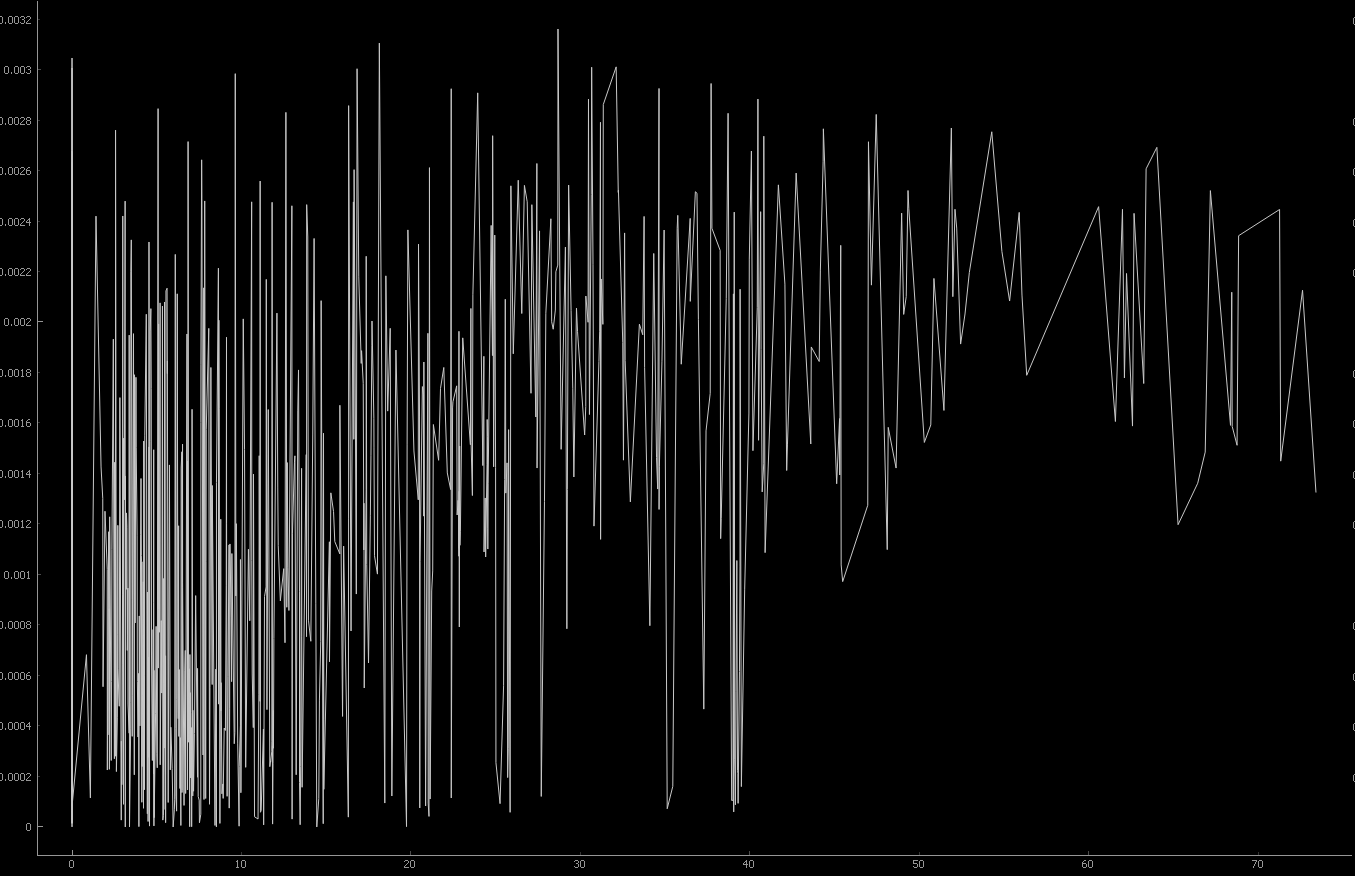

## Position Dataframe Binning in Time:

# Test PfND_TimeDependent Class

In [ ]:
from copy import deepcopy
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from neuropy.plotting.placemaps import plot_all_placefields

# PfND version:
t_list = []
ratemaps_list = []
active_time_dependent_placefields2D = active_pf_2D_dt
# np.shape(active_time_dependent_placefields2D.curr_firing_maps_matrix) # (64, 64, 29)

# t = active_time_dependent_placefields2D.last_t + 60 # add one second
# with np.errstate(divide='ignore', invalid='ignore'):
#     active_time_dependent_placefields2D.update(t)
t = active_time_dependent_placefields2D.step(60.0) # advance sixty seconds.

In [ ]:
active_time_dependent_placefields2D.reset()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
active_time_dependent_placefields2D.plot_ratemaps_2D()

In [ ]:
from copy import deepcopy
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedOccupancyPlotter import TimeSynchronizedOccupancyPlotter

curr_occupancy_plotter = TimeSynchronizedOccupancyPlotter(active_time_dependent_placefields2D)
curr_occupancy_plotter.show()

In [ ]:
# Control Occupancy Plotter by spike_raster_window:
occupancy_raster_window_sync_connection = spike_raster_window.connect_controlled_time_synchronized_plotter(curr_occupancy_plotter)

In [ ]:
active_time_dependent_placefields2D.plot_occupancy()

In [ ]:
## Test TimeSynchronizedPlacefieldsPlotter:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

curr_placefields_plotter = TimeSynchronizedPlacefieldsPlotter(active_time_dependent_placefields2D)
curr_placefields_plotter.show()

In [ ]:
# Control Placefields Plotter by spike_raster_window:
placefields_raster_window_sync_connection = spike_raster_window.connect_controlled_time_synchronized_plotter(curr_placefields_plotter)

## Explore Snapshotting for active_pf_*D_dt:

In [ ]:
active_pf_1D_dt = curr_active_pipeline.computation_results['maze1'].computed_data['pf1D_dt']
active_pf_2D_dt = curr_active_pipeline.computation_results['maze1'].computed_data['pf2D_dt']
active_pf_1D_dt

In [ ]:
active_pf_1D_dt

In [ ]:
active_pf_2D_dt.last_t

In [ ]:
active_pf_2D_dt.curr_seconds_occupancy, 

## Old TimeSynchronized*Plotter Testing

In [ ]:
t = curr_occupancy_plotter.active_time_dependent_placefields.last_t + 7 # add one second
# with np.errstate(divide='ignore', invalid='ignore'):
# active_time_dependent_placefields.update(t)
print(f't: {t}')
curr_occupancy_plotter.on_window_changed(0.0, t)
curr_placefields_plotter.on_window_changed(0.0, t)

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image, pyqtplot_plot_image_array
import time

def _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ plots a single result at a given time.
    
    Creates the figures if needed, otherwise updates the existing ones.
    
    """
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.

    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map

    imv = output_plots_dict.get('occupancy', {}).get('imv', None)
    if imv is None:
        # Otherwise build the plotter:
        occupancy_app, occupancy_win, imv = pyqtplot_plot_image(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, occupancy)
        output_plots_dict['occupancy'] = dict(zip(('app', 'win', 'imv'), (occupancy_app, occupancy_win, imv)))   
        occupancy_win.show()
    else:
        # Update the existing one:
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)

    pg.QtGui.QApplication.processEvents() # call to ensure the occupancy gets updated before starting the placefield plots:
    
    img_item_array = output_plots_dict.get('placefields', {}).get('img_item_array', None)
    if img_item_array is None:
        # Create a new one:
        placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin,
                                                                                                                                           active_time_dependent_placefields2D.ratemap.normalized_tuning_curves, active_time_dependent_placefields2D.curr_raw_occupancy_map)#, 
        output_plots_dict['placefields'] = dict(zip(('app', 'win', 'root_render_widget', 'plot_array', 'img_item_array', 'other_components_array'), (placefields_app, placefields_win, root_render_widget, plot_array, img_item_array, other_components_array)))
        placefields_win.show()

    else:
        # Update the placefields plot if needed:
        images = curr_ratemap.tuning_curves # (43, 63, 63)
        for i, an_img_item in enumerate(img_item_array):
            image = np.squeeze(images[i,:,:])
            # Pre-filter the data:
            # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
            if drop_below_threshold is not None:
                image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
            # an_img_item.setImage(np.squeeze(images[i,:,:]))
            an_img_item.setImage(image)

    return output_plots_dict

In [ ]:
def pre_build_iterative_results(num_iterations=50, t_list=[], ratemaps_list=[]):
    """ 
    build up historical data arrays:
    
    Usage:
        t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
    """
    # t_list = []
    # ratemaps_list = []
    
    def _step_plot(time_step_seconds):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        t_list.append(t)
        with np.errstate(divide='ignore', invalid='ignore'):
            active_time_dependent_placefields2D.update(t)
        # Loop through and update the plots:
        # Get flat list of images:
        curr_ratemap = active_time_dependent_placefields2D.ratemap
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        # images = active_time_dependent_placefields2D.ratemap.normalized_tuning_curves[0:40,:,:] # (43, 63, 63)
        # occupancy = curr_ratemap.occupancy
        ratemaps_list.append(curr_ratemap)
    #     for i, an_img_item in enumerate(img_item_array):
    #     # for i, a_plot in enumerate(plot_array):
    #         # image = np.squeeze(images[i,:,:])
    #         # Pre-filter the data:
    #         # image = np.array(image.copy()) / np.nanmax(image) # note scaling by maximum here!
    # #         if drop_below_threshold is not None:
    # #             image[np.where(occupancy < drop_below_threshold)] = np.nan # null out the occupancy        
    #         an_img_item.setImage(np.squeeze(images[i,:,:]))
    
    for i in np.arange(num_iterations):
        _step_plot(time_step_seconds=1.0)
    
    return t_list, ratemaps_list

# Loop through the historically collected ratemaps and plot them:
def _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ Uses the previously built-up t_list and ratemaps_list (as computed by pre_build_iterative_results(...)) to plot the time-dependent results.
    requires:
    imv: a previously created single-image plotter:
    """
    num_historical_results = len(ratemaps_list)
    assert len(t_list) == len(ratemaps_list), f"len(t_list): {len(t_list)} needs to equal len(ratemaps_list): {len(ratemaps_list)}"
    
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {},
                            'placefields': {}} # make a new dictionary to hold the plot objects.
        
    for i in np.arange(num_historical_results):
        curr_t = t_list[i]
        # Set up
        # print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    
        pg.QtGui.QApplication.processEvents()
        time.sleep(0.1) # Sleep for 0.5 seconds

    return output_plots_dict

# Build the Historical Results:
t_list, ratemaps_list = pre_build_iterative_results(num_iterations=50, t_list=t_list, ratemaps_list=ratemaps_list)
# Plot the historical results:
if output_plots_dict is None:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}
output_plots_dict = _test_plot_historical_iterative_pf_results(t_list, ratemaps_list, output_plots_dict=output_plots_dict)

In [ ]:
# Compute the time-dependent ratemap info in real-time and plot them:
def _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ 
    requires:
    imv: a previously created single-image plotter:
    """
    # Compute the updated placefields/occupancy for the time t:
    with np.errstate(divide='ignore', invalid='ignore'):
        active_time_dependent_placefields2D.update(t)
    # Update the plots:
    curr_t = active_time_dependent_placefields2D.last_t
    curr_ratemap = active_time_dependent_placefields2D.ratemap

    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}} # make a new dictionary to hold the plot objects.
        
    # Plot the results directly from the active_time_dependent_placefields2D
    output_plots_dict = _test_plot_curr_pf_result(curr_t, curr_ratemap, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
    pg.QtGui.QApplication.processEvents()
    
    return output_plots_dict

def _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, drop_below_threshold: float=0.0000001, output_plots_dict=None):
    """ performs num_iterations time steps of size time_step_seconds and plots the results. """
    for i in np.arange(num_iterations):
        t = active_time_dependent_placefields2D.last_t + time_step_seconds # add one second
        output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, t, drop_below_threshold=drop_below_threshold, output_plots_dict=output_plots_dict)
        time.sleep(0.1) # Sleep for 0.5 seconds

In [ ]:
try:
    if output_plots_dict is None:
        output_plots_dict = {'occupancy': {}, 'placefields': {}}
except NameError:
    output_plots_dict = {'occupancy': {}, 'placefields': {}}

output_plots_dict = _test_live_iterative_pf_results_plot(active_time_dependent_placefields2D, num_iterations=50, time_step_seconds=1.0, output_plots_dict=output_plots_dict)

In [ ]:
output_plots_dict = {'occupancy': {}, 'placefields': {}} # clear the output plots dict
output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, spike_raster_window.spikes_window.active_time_window[1], output_plots_dict=output_plots_dict)

In [ ]:
def _on_window_updated(window_start, window_end):
    # print(f'_on_window_updated(window_start: {window_start}, window_end: {window_end})')
    global output_plots_dict
    ## Update only version:
    # with np.errstate(divide='ignore', invalid='ignore'):
    #     active_time_dependent_placefields2D.update(window_end) # advance the placefield display to the end of the window.
    ## Update and plot version:
    # t = window_end
    output_plots_dict = _test_step_live_iterative_pf_results_plot(active_time_dependent_placefields2D, window_end, output_plots_dict=output_plots_dict)
    
# spike_raster_window.connect_additional_controlled_plotter(_on_window_updated)

_on_window_updated(spike_raster_window.spikes_window.active_time_window[0], spike_raster_window.spikes_window.active_time_window[1])
sync_connection = spike_raster_window.spike_raster_plt_2d.window_scrolled.connect(_on_window_updated) # connect the window_scrolled event to the _on_window_updated function

In [ ]:
spike_raster_window.connect_additional_controlled_plotter(

In [ ]:
active_time_dependent_placefields2D.plot_occupancy()

In [ ]:
# active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=False) # Works
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_spike_overlay=True)

In [ ]:
# t_list
active_time_dependent_placefields2D.plot_ratemaps_2D(enable_saving_to_disk=False, enable_spike_overlay=False)

In [ ]:
# ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(None, active_time_dependent_placefields2D, active_config_name)
occupancy_fig, occupancy_ax = active_time_dependent_placefields2D.plot_occupancy(identifier_details_list=[])

In [ ]:
i = 0
while (i < len(t_list)):
    curr_t = t_list[i]
    # Set up
    print(f'curr_t: {curr_t}')
    curr_ratemap = ratemaps_list[i]
    # images = curr_ratemap.tuning_curves # (43, 63, 63)
    occupancy = curr_ratemap.occupancy
    # occupancy = curr_ratemap.curr_raw_occupancy_map
    imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
    i += 1
    pg.QtGui.QApplication.processEvents()
    
print(f'done!')

In [ ]:
# Timer Update Approach:
timer = pg.QtCore.QTimer()
i = 0
def update():
    if (i < len(t_list)):
        curr_t = t_list[i]
        # Set up
        print(f'curr_t: {curr_t}')
        curr_ratemap = ratemaps_list[i]
        # images = curr_ratemap.tuning_curves # (43, 63, 63)
        occupancy = curr_ratemap.occupancy
        # occupancy = curr_ratemap.curr_raw_occupancy_map
        imv.setImage(occupancy, xvals=active_time_dependent_placefields2D.xbin)
        i += 1
    else:
        print(f'done!')
    # pw.plot(x, y, clear=True)

timer.timeout.connect(update)

In [ ]:
# timer.start(16)
timer.start(500)


In [ ]:
timer.stop()

In [ ]:
t_list

## Other

In [ ]:
curr_occupancy_weighted_tuning_maps_matrix = compute_occupancy_weighted_tuning_map(curr_seconds_occupancy, curr_firing_maps_matrix)
curr_occupancy_weighted_tuning_maps_matrix

In [ ]:
xy = active_pos_df[['x','y']].to_numpy().T
x = xy[0,:] # (57247,)
y = xy[1,:]

In [ ]:
print(f'np.nanmin(xbin): {np.nanmin(xbin)}') # 34.412589400527594
print(f'np.nanmin(ybin): {np.nanmin(ybin)}') # 126.93492802111207

print(f'np.nanmax(xbin): {np.nanmax(xbin)}') # 257.2462592450022
print(f'np.nanmax(ybin): {np.nanmax(ybin)}') # 148.84479357012503
# active_pos_df.notnull() # (57247,)
# np.shape(x) # (57247,)

In [ ]:
app_mine, win_mine, imv_mine = pyqtplot_plot_image(xbin, ybin, curr_occupancy_map)
win_mine.show()

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph.graphicsItems.ViewBox.axisCtrlTemplate_pyqt5

# Test Iterative building

In [ ]:
t = last_t + 1 # add one second
curr_t, curr_occupancy_map = update_occupancy_map(last_t, curr_occupancy_map, t, active_pos_df, active_spike_df)
curr_occupancy_map

In [ ]:
t = 2000.0 # the "current time" for which to build the best possible placefields
last_t, curr_occupancy_map = update_occupancy_map(0, curr_occupancy_map, t, active_pos_df, active_spike_df)

In [ ]:
from neuropy.analyses.placefields import PfND # for build_position_df_discretized_binned_positions
active_computation_config = active_session_computation_configs[0]
xbin, ybin, bin_info = PfND._bin_pos_nD(active_pos_df['x'].values, active_pos_df['y'].values, bin_size=active_computation_config.grid_bin) # bin_size mode

# ybin
np.nanmax(sess.position.to_dataframe().y) # 153.31348420699553
# np.nanmax(active_pos_df.y) # 148.32098247462739
ybin

In [ ]:
# Alternative implemention for position dataframe bin counting using group_by
np.unique(active_pos_df.binned_x) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
np.unique(active_pos_df.binned_y) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, nan])

# active_current_pos_df = active_pos_df.position.time_sliced(0, 30000)

# np.unique(active_current_pos_df.binned_x) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
# np.unique(active_current_pos_df.binned_y) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, nan])

curr_grouped_occupancy_map = np.zeros((n_xbins, n_ybins), dtype=int) # create an initially zero occupancy map
grouped = active_pos_df[['t','binned_x','binned_y']].groupby(['binned_x','binned_y'])
grouped_count = grouped.count()
# grouped_count.index.to_flat_index()

flat_indicies = grouped_count.index.to_flat_index()
counts = grouped_count['t'].to_numpy()

# for (xbin_label, ybin_label), count in current_bin_counts.iteritems():

# curr_grouped_occupancy_map[np.array(grouped_count.index.to_flat_index())] = grouped_count.values


for i in np.arange(len(counts)):
    curr_grouped_occupancy_map[flat_indicies[i]] = counts[i]

curr_grouped_occupancy_map
# for idx, group in grouped_count.iteritems():
#     print(idx)
    
    # curr_grouped_occupancy_map
    
np.sum(np.sum(curr_grouped_occupancy_map)) # 55206
active_pos_df

In [ ]:
# 

np.shape(active_computed_data['pf2D'].ratemap.xbin) # (60,)
np.shape(active_computed_data['pf2D'].ratemap.ybin) # (22,)

np.shape(active_computed_data['pf2D'].ratemap.xbin_centers) # (59,)
np.shape(active_computed_data['pf2D'].ratemap.ybin_centers) # (21,)

# np.shape(active_computed_data['pf2D'].ratemap.occupancy) # (59, 21)

# active_spike_df
# xbin_labels

In [ ]:
# active_pos_df['binned_x']
# binned_x_vals = active_pos_df['binned_x'].astype(float, copy=True).to_numpy()
# binned_y_vals = active_pos_df['binned_y'].astype(float, copy=True).to_numpy() # 57247

binned_x_indicies = active_pos_df['binned_x'].astype(float, copy=True).to_numpy()
binned_y_indicies = active_pos_df['binned_y'].astype(float, copy=True).to_numpy() # 57247

active_pos_df['binned_x_indicies'] = binned_x_indicies
active_pos_df['binned_y_indicies'] = binned_y_indicies
# np.unique(binned_x_vals) # array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, nan])
# binned_y_vals
# active_pos_df['binned_y']
np.shape(np.where(np.isnan(binned_x_vals))) # (1, 1321)
np.shape(np.where(np.isnan(binned_y_vals))) # (1, 768)

# np.where(pd.isnull(active_pos_df[['binned_x_indicies','binned_y_indicies']]))
# np.where(pd.isna(active_pos_df[['binned_x_indicies','binned_y_indicies']]))

np.where(pd.isnull(active_pos_df['binned_x_indicies']))

any_row_nan_indicies = np.where(np.logical_or(pd.isnull(active_pos_df['binned_x_indicies']), pd.isnull(active_pos_df['binned_y_indicies'])))
any_row_nan_indicies

print(f'any_row_nan_indicies: {np.shape(any_row_nan_indicies)}') # (1, 2041)


# np.where(pd.isnull(active_pos_df[['binned_x_indicies','binned_y_indicies']]))
# np.isnan(active_pos_df[['binned_x_indicies','binned_y_indicies']])

# active_pos_df['binned_x_indicies']

In [ ]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
# raw_occupancy = raw_occupancy.T
fig = plt.figure(figsize=(7, 3))
# ax = fig.add_subplot(111, title='imshow: square bins')
# plt.imshow(raw_occupancy, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = fig.add_subplot(111, title='NonUniformImage: interpolated', aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
print(f'xcenters: {xcenters.shape}, ycenters: {ycenters.shape}, raw_occupancy: {raw_occupancy.shape}')
im.set_data(xcenters, ycenters, raw_occupancy.T)
ax.images.append(im)
plt.show()

In [ ]:
current_bin_counts['binned_x']

# current_bin_counts.index.to_flat_index()

for name, group in grouped:
    print(name)
    print(group)

In [ ]:
# Binning in Time:
aligned_active_pos_df = active_pos_df.copy()

time_window_edges_time_delta = pd.to_timedelta(active_one_step_decoder.time_window_edges, unit="sec") # convert the windows to timedeltas as well to allow efficient comparison
time_window_edges_time_delta # length=1718

# aligned_active_pos_df.between_time

# aligned_active_pos_df.at_time(pho_custom_decoder.time_window_edges)

# pho_custom_decoder.time_window_edges
# aligned_active_pos_df.align(time_window_edges_time_delta, fill_value=np.nan)

# build_position_df_time_window_idx(active_pos_df, pho_custom_decoder.active_time_window_centers)

# pho_custom_decoder.active_time_window_centers
# pho_custom_decoder.time_window_edges

# s21, s22 = ts_2.align(ts_1, fill_value=0)

# active_sess.position.df
# aligned_active_pos_df

In [ ]:
# from pyphoplacecellanalysis.General.Decoder.decoder_result import DecoderResultDisplayingPlot2D
# def _display_decoder_result():
#     renderer = DecoderResultDisplayingPlot2D(pho_custom_decoder, active_pos_df)
#     def animate(i):
#         # print(f'animate({i})')
#         return renderer.display(i)
#     interact(animate, i=(0, pho_custom_decoder.num_time_windows, 10))

curr_kdiba_pipeline.display(DefaultDisplayFunctions._display_decoder_result, 'maze1', show_posterior=True) # works!

In [ ]:
_display_result(curr_kdiba_pipeline.computation_results['maze1'])
_display_result(curr_kdiba_pipeline.computation_results['maze2'])

In [ ]:
import matplotlib.pyplot as plt
from neuropy.utils.misc import is_iterable
from neuropy.plotting.figure import pretty_plot
from scipy.ndimage import gaussian_filter, gaussian_filter1d, interpolation

from pyphoplacecellanalysis.Analysis.reliability import compute_lap_to_lap_reliability

from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d


def _test_plotRaw_v_time(active_pf, cellind, speed_thresh=False, alpha=0.5, ax=None):
        """ Builds one subplot for each dimension of the position data
        
        Updated to work with both 1D and 2D Placefields """   
        if ax is None:
            fig, ax = plt.subplots(active_pf.ndim, 1, sharex=True)
            fig.set_size_inches([23, 9.7])
        
        if not is_iterable(ax):
            ax = [ax]
            
        # plot trajectories
        if active_pf.ndim < 2:
            variable_array = [active_pf.x]
            label_array = ["X position (cm)"]
        else:
            variable_array = [active_pf.x, active_pf.y]
            label_array = ["X position (cm)", "Y position (cm)"]
            
        for a, pos, ylabel in zip(ax, variable_array, label_array):
            a.plot(active_pf.t, pos)
            a.set_xlabel("Time (seconds)")
            a.set_ylabel(ylabel)
            pretty_plot(a)

        # Grab correct spike times/positions
        if speed_thresh:
            spk_pos_, spk_t_ = active_pf.run_spk_pos, active_pf.run_spk_t
        else:
            spk_pos_, spk_t_ = active_pf.spk_pos, active_pf.spk_t

        # plot spikes on trajectory
        for a, pos in zip(ax, spk_pos_[cellind]):
            a.plot(spk_t_[cellind], pos, ".", color=[0, 0, 0.8, alpha])

        # Put info on title
        ax[0].set_title(
            "Cell "
            + str(active_pf.cell_ids[cellind])
            + ":, speed_thresh="
            + str(active_pf.speed_thresh)
        )
        return ax


curr_result_label = 'maze1'
sess = curr_kdiba_pipeline.filtered_sessions[curr_result_label]
sess = curr_kdiba_pipeline.sess

In [ ]:
curr_laps_df = sess.laps.to_dataframe()
curr_laps_df

In [ ]:
pos_df = sess.compute_position_laps() # ensures the laps are computed if they need to be:
position_obj = sess.position
position_obj.compute_higher_order_derivatives()
pos_df = position_obj.compute_smoothed_position_info(N=20) ## Smooth the velocity curve to apply meaningful logic to it
pos_df = position_obj.to_dataframe()
pos_df

In [ ]:
# fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=True)
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

curr_cell_idx = 2 
# curr_cell_idx = 3 # good for end platform analysis
curr_cell_ID = sess.spikes_df.spikes.neuron_ids[curr_cell_idx]
print(f'curr_cell_idx: {curr_cell_idx}, curr_cell_ID: {curr_cell_ID}')

# pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
filtered_spikes_df = sess.spikes_df.copy()
time_variable_name = filtered_spikes_df.spikes.time_variable_name # 't_rel_seconds'

lap_ids = sess.laps.lap_id
# lap_flat_idxs = sess.laps.get_lap_flat_indicies(lap_ids)

out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap = compute_lap_to_lap_reliability(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], filtered_spikes_df, lap_ids, curr_cell_idx, debug_print=False, plot_results=True);

# compute_reliability_metrics(out_indicies, out_digitized_position_bins, out_within_lap_spikes_overlap, debug_print=False, plot_results=False)

# # curr_kdiba_pipeline.computation_results['maze1'].computed_data['pf2D'].plotRaw_v_time(curr_cell_idx)
# _test_plotRaw_v_time(curr_kdiba_pipeline.computation_results[curr_result_label].computed_data['pf2D'], curr_cell_idx)

# 3D Lap Plotting Experimentation

In [ ]:
from itertools import islice # for Pagination class
import pyvista as pv
import pyvistaqt as pvqt
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin
from pyphocorehelpers.gui.PyVista.PhoCustomVtkWidgets import PhoWidgetHelper
from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import perform_plot_flat_arena, _build_flat_arena_data

""" Test Drawing Spike Lines """
# from pyphoplacecellanalysis.Pho3D.spikes import draw_line_spike, lines_from_points
from pyphoplacecellanalysis.Pho3D.points import interlieve_points

from pyphoplacecellanalysis.PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_pointdata_df

def _plot_all_lap_spikes(p, sess, included_cell_IDXs, included_lap_IDXs, debug_print=True, lap_start_z=0.0, lap_id_dependent_z_offset=10.0):
    should_reinterpolate_spike_positions = False
        
    def _plot_single_spikes(p, cell_specific_spikes_dfs, placefield_cell_index):
        curr_cell_spike_df = cell_specific_spikes_dfs[placefield_cell_index]
        # curr_cell_spike_df['z_fixed'] = np.full_like(active_flat_df['x'].values, 1.1)
        pdata = build_active_spikes_plot_pointdata_df(curr_cell_spike_df)

        # curr_cell_spike_times = curr_cell_spike_df[curr_cell_spike_df.spikes.time_variable_name].to_numpy()  # (271,)
        # curr_cell_spike_positions = curr_cell_spike_df['x','y'].to_numpy()  # (271,)

        # lines_from_points(
        # p[0,0].add_points(pdata, name='plot_single_spikes_points', render_points_as_spheres=True, point_size=5.0)

        # Build offset points and spike data:
        spike_height = max((lap_id_dependent_z_offset * 0.6), 0.5) # half the line height

        # start_points = pdata.points.copy()
        # end_points = start_points.copy()
        # # end_points[:,2] # get z values
        # end_points[:,2] = end_points[:,2] + spike_height
        # all_points = interlieve_points(start_points, end_points)
        # lines_poly_data = pv.PolyData()
        # lines_poly_data.points = all_points
        # # cells = np.hstack(([2, 0, 1],[2, 1, 2]))
        # num_lines = np.shape(start_points)[0]
        # cells = [[2, 2*i, 2*i+1] for i in np.arange(num_lines)]
        # lines_poly_data.lines = cells
        
        p[0,0].add_mesh(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0, color='white')        
        
        # p[0,0].add_points(pdata, name=f'plot_single_spikes_points[{placefield_cell_index}]', render_points_as_spheres=True, point_size=5.0)
        # p[0,0].add_mesh(lines_poly_data, name=f'plot_single_spikes_lines[{placefield_cell_index}]', render_points_as_spheres=False, point_size=5.0)
        # return {'pdata':pdata, 'lines_poly_data':lines_poly_data}
        
        return {'pdata':pdata}
    
    time_variable_name = sess.spikes_df.spikes.time_variable_name # 't_rel_seconds'
    # sets the 'z_fixed' value for all spikes in sess.spikes_df, which will be used to plot them as points
    sess.spikes_df['z'] = lap_start_z + (lap_id_dependent_z_offset * sess.spikes_df.lap.to_numpy())

    if debug_print:
        print(f'sess.laps.lap_id: {sess.laps.lap_id}')
        
    included_cell_IDXs = np.array(included_cell_IDXs)
    included_lap_IDXs = np.array(included_lap_IDXs)
    
    # ensure that only lap_ids included in this session are used:
    included_lap_ids = sess.laps.lap_id[included_lap_IDXs]
    possible_included_lap_ids = np.unique(sess.spikes_df.lap.values)
    if debug_print:
        print(f'np.unique(sess.spikes_df.lap.values): {np.unique(sess.spikes_df.lap.values)}')
    included_lap_ids = included_lap_ids[np.isin(included_lap_ids, possible_included_lap_ids)]
    if debug_print:
        print(f'included_lap_ids: {included_lap_ids}')
    
    # get the included cell IDs
    included_cell_IDs = np.array(sess.spikes_df.spikes.neuron_ids)[included_cell_IDXs]
        
    # print(np.isin(['R','G','B','render_opacity'], sess.spikes_df.columns).all())

    # POSITIONS:
    curr_position_df, lap_specific_position_dfs, lap_specific_time_ranges, lap_specific_position_traces = LapsVisualizationMixin._compute_laps_position_data(sess)
    
    # SPIKES:
    # # grouped by lap
    # lap_grouped_spikes_df = sess.spikes_df.groupby('lap')
    # lap_specific_spikes_dfs = [lap_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_lap_ids] # dataframes split for each ID:

    # grouped by cell:
    # pre-filter by spikes that occur in one of the included laps for the filtered_spikes_df
    filtered_spikes_df = sess.spikes_df.copy()
    filtered_spikes_df = filtered_spikes_df[np.isin(filtered_spikes_df['lap'], included_lap_ids)] # get only the spikes that occur in one of the included laps for the filtered_spikes_df
    
    
    # Interpolate the spikes positions again:
    if should_reinterpolate_spike_positions:
        print('Re-interpolating spike positions...')
        filtered_spikes_df = filtered_spikes_df.spikes.interpolate_spike_positions(curr_position_df['t'].to_numpy(), curr_position_df['x'].to_numpy(), curr_position_df['y'].to_numpy())
        # filtered_spikes_df = FlattenedSpiketrains.interpolate_spike_positions(filtered_spikes_df, session.position.time, session.position.x, session.position.y, spike_timestamp_column_name=time_variable_name)
    
    cell_grouped_spikes_df = filtered_spikes_df.groupby('aclu')
    cell_specific_spikes_dfs = [cell_grouped_spikes_df.get_group(i)[[time_variable_name,'aclu','lap','flat_spike_idx','cell_type','x','y','lin_pos','z']] for i in included_cell_IDs] # dataframes split for each ID:

    # lap_specific_position_dfs = _compute_laps_position_data(sess)

    # # Positions:
    # curr_position_df = sess.compute_position_laps()
    # included_pos_lap_ids = np.unique(curr_position_df.lap.values)
    # print(f'np.unique(curr_position_df.lap.values): {np.unique(curr_position_df.lap.values)}')
    # included_pos_lap_ids = included_pos_lap_ids[np.isin(included_pos_lap_ids, sess.laps.lap_id)]
    # included_pos_lap_ids

    # print(f'included_pos_lap_ids: {included_pos_lap_ids}')

    # lap_grouped_position_df = curr_position_df.groupby('lap')
    # lap_specific_position_dfs = [lap_grouped_position_df.get_group(i)[['t','aclu','x','y','lin_pos']] for i in included_lap_ids] # dataframes split for each ID:

    for i, curr_cell_ID in enumerate(included_cell_IDs):
        plot_data_dict = _plot_single_spikes(p, cell_specific_spikes_dfs, i)


# sess = curr_kdiba_pipeline.filtered_sessions['maze']
# included_cell_IDXs = [6]
# included_lap_IDXs = [2, 3]
# _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_IDXs, included_lap_IDXs)

from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

lap_start_z = 0.0
# lap_id_dependent_z_offset = 0.0
lap_id_dependent_z_offset = 3.0
# curr_kdiba_pipeline.active_configs['maze1'].lap_id_dependent_z_offset = 3.0

def _display_testing(sess, computation_result, active_config, extant_plotter=None):
    """ Testing of plot_lap_trajectories_2d """
    # print(f'active_config.plotting_config: {active_config.plotting_config}')
    single_combined_plot=True
    if single_combined_plot:
        default_plotting = True
    else:
        default_plotting = False
    active_config.plotting_config.plotter_type = 'MultiPlotter'
    # print(f'active_config.plotting_config: {active_config.plotting_config}')
    iplapsDataExplorer = InteractiveCustomDataExplorer(active_config, sess, extant_plotter=extant_plotter)
    pActiveInteractiveLapsPlotter = iplapsDataExplorer.plot(pActivePlotter=extant_plotter, default_plotting=default_plotting)
    # included_cell_idxs = None
    included_cell_idxs = [0, 1]
    # included_lap_idxs = [2, 5, 9, 12]
    included_lap_idxs = [2]
    # All
    # included_cell_idxs = np.arange(len(sess.spikes_df.spikes.neuron_ids))
    # included_lap_idxs = np.arange(len(sess.laps.lap_id))
    from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_lap_trajectories_3d
    pActiveInteractiveLapsPlotter, laps_pages = plot_lap_trajectories_3d(sess, curr_num_subplots=5, active_page_index=0, included_lap_idxs=included_lap_idxs, single_combined_plot=single_combined_plot, 
                                                                         lap_start_z = lap_start_z, lap_id_dependent_z_offset = lap_id_dependent_z_offset,
                                                                         existing_plotter=pActiveInteractiveLapsPlotter)

    # add the spikes for the curves:
    _plot_all_lap_spikes(pActiveInteractiveLapsPlotter, sess, included_cell_idxs, included_lap_idxs, lap_start_z=lap_start_z, lap_id_dependent_z_offset=lap_id_dependent_z_offset)
    return iplapsDataExplorer, pActiveInteractiveLapsPlotter


# curr_kdiba_pipeline.computation_results['maze1'].computation_config
# curr_kdiba_pipeline.computation_results['maze1'].sess.config
# curr_kdiba_pipeline.active_configs['maze1']

curr_result_label = 'maze1'
# sess = curr_active_pipeline.filtered_sessions[curr_result_label]
# sess = curr_active_pipeline.sess

pActiveInteractiveLapsPlotter = None
try: pActiveInteractiveLapsPlotter
except NameError: pActiveInteractiveLapsPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
iplapsDataExplorer, pActiveInteractiveLapsPlotter = _display_testing(sess, curr_active_pipeline.computation_results[curr_result_label], curr_active_pipeline.active_configs[curr_result_label],
                                                                     extant_plotter=pActiveInteractiveLapsPlotter)
pActiveInteractiveLapsPlotter.show()

In [ ]:
sess.laps

In [ ]:
# lines_from_points(pdata.points)

np.shape(all_points)

In [ ]:
p, laps_pages = _plot_lap_trajectories_combined_plot_3d(curr_kdiba_pipeline.sess, curr_num_subplots=5, single_combined_plot=False)
p.show()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d
fig, out_axes_list = plot_laps_2d(sess, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')

In [ ]:
# sess.laps.to_dataframe()
# sess.position.to_dataframe()
# sess.position
# curr_active_pipeline.sess.laps

# curr_active_pipeline.sess.laps

curr_active_pipeline.sess.position.to_dataframe()

In [ ]:
ipspikesDataExplorer.get_plot_objects_list

In [ ]:
ipspikesDataExplorer.spikes_main_historical.SetVisibility(False)

In [ ]:
from vedo.io import exportWindow, write
# exportWindow('testOutFilePho.html')
# exportWindow('testOutFilePho.x3d')

# pActiveTuningCurvesPlotter.save('testPlotterSavePho.obj')
# write(pActiveTuningCurvesPlotter,'testPlotterSavePho.obj')
# pActiveTuningCurvesPlotter.write_frame('testPlotter_write_frame_Pho')
# pActiveTuningCurvesPlotter.export('testPlotterSavePho.x3d')


export_path = Path(r'C:\Users\pho\repos\PhoPy3DPositionAnalysis2021\EXTERNAL\Screenshots\PyVista-Based\InteractivePlaceCellDataExplorer\Exported 3D Objects')
# export_path.exists()


# export_file_prefix_name = 'testPlotter_export_obj_Pho.obj'

export_app_name = 'pActiveSpikesBehaviorPlotter'
export_file_prefix_name = 'testSpikesBehaviorPlotter'

export_obj_path = export_path.joinpath('_'.join([export_file_prefix_name, 'export_obj', 'Pho']))
# export_obj_path = export_path.joinpath('testSpikesBehaviorPlotter_export_obj_Pho.obj')

export_html_path = export_path.joinpath('_'.join([export_file_prefix_name, 'export_html', 'Pho']))

# export_obj_path

In [ ]:
## Success, but ugly:
pActiveSpikesBehaviorPlotter.export_html(export_html_path) ## First export that actually works with BackgroundPlotter
pActiveSpikesBehaviorPlotter.export_obj(export_obj_path) ## Works for exporting .obj files

In [ ]:
# pActiveSpikesBehaviorPlotter.add_floor()
# pActiveSpikesBehaviorPlotter.remove_floors()

In [ ]:
pActiveSpikesBehaviorPlotter.background_color = 'red'

In [ ]:
# pActiveSpikesBehaviorPlotter.button_widgets(
# maze_bg_mesh = ipspikesDataExplorer.plots_data['maze_bg']
maze_bg_mesh = ipspikesDataExplorer.plots['maze_bg']

In [ ]:
pActiveSpikesBehaviorPlotter.mesh

In [ ]:
ipspikesDataExplorer.plots_data.keys()

In [ ]:
pv.save_meshio('maze_bg_mesh.inp', maze_bg_mesh) 

In [ ]:
pActiveSpikesBehaviorPlotter.export_html(

In [ ]:
ipcDataExplorer.cur

# 3D Curves Testing

In [ ]:
# get properties from spike_raster_window:

active_curve_plotter_3d = test_independent_vedo_raster_widget # use separate vedo plotter
# active_curve_plotter_3d = spike_raster_window.spike_raster_plt_3d
curr_computations_results = curr_active_pipeline.computation_results[active_config_name]

In [ ]:
## Spike Smoothed Moving Average Rate:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Specific3DTimeCurves import Specific3DTimeCurvesHelper
binned_spike_moving_average_rate_curve_datasource = Specific3DTimeCurvesHelper.add_unit_time_binned_spike_visualization_curves(curr_computations_results, active_curve_plotter_3d, spike_visualization_mode='mov_average')            

In [ ]:
# Get current plot items:
curr_plot3D_active_window_data = active_curve_plotter_3d.params.time_curves_datasource.get_updated_data_window(active_curve_plotter_3d.spikes_window.active_window_start_time, active_curve_plotter_3d.spikes_window.active_window_end_time) # get updated data for the active window from the datasource
is_data_series_mode = active_curve_plotter_3d.params.time_curves_datasource.has_data_series_specs
if is_data_series_mode:
    data_series_spaital_values_list = active_curve_plotter_3d.params.time_curves_datasource.data_series_specs.get_data_series_spatial_values(curr_plot3D_active_window_data)
    num_data_series = len(data_series_spaital_values_list)

curr_data_series_index = 0
curr_data_series_dict = data_series_spaital_values_list[curr_data_series_index]

curr_plot_column_name = curr_data_series_dict.get('name', f'series[{curr_data_series_index}]') # get either the specified name or the generic 'series[i]' name otherwise
curr_plot_name = active_curve_plotter_3d.params.time_curves_datasource.datasource_UIDs[curr_data_series_index]
# points for the current plot:
pts = np.column_stack([curr_data_series_dict['x'], curr_data_series_dict['y'], curr_data_series_dict['z']])
pts

In [ ]:
## Add the new filled plot item:
plot_args = ({'color_name':'white','line_width':0.5,'z_scaling_factor':1.0})
_test_fill_plt = gl.GLLinePlotItem(pos=points, color=line_color, width=plot_args.setdefault('line_width',0.5), antialias=True)
_test_fill_plt.scale(1.0, 1.0, plot_args.setdefault('z_scaling_factor',1.0)) # Scale the data_values_range to fit within the z_max_value. Shouldn't need to be adjusted so long as data doesn't change.            
# plt.scale(1.0, 1.0, self.data_z_scaling_factor) # Scale the data_values_range to fit within the z_max_value. Shouldn't need to be adjusted so long as data doesn't change.
active_curve_plotter_3d.ui.main_gl_widget.addItem(_test_fill_plt)

In [ ]:
active_curve_plotter_3d.plots.keys()

In [ ]:
active_curve_plotter_3d.params.render_epochs

In [ ]:
active_curve_plotter_3d.params.time_curves_datasource

In [ ]:
active_curve_plotter_3d.params.time_curves_enable_baseline_grid = True
active_curve_plotter_3d.params.time_curves_baseline_grid_alpha = 0.9
# add_3D_time_curves_baseline_grid_mesh

In [ ]:
active_curve_plotter_3d.add_3D_time_curves_baseline_grid_mesh()

In [ ]:
active_curve_plotter_3d.remove_3D_time_curves_baseline_grid_mesh()

In [ ]:
list(active_curve_plotter_3d.plots.keys())

In [ ]:
active_curve_plotter_3d.plots.time_curve_helpers

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.TimeCurves3D.Render3DTimeCurvesBaseGridMixin import BaseGrid3DTimeCurvesHelper, Render3DTimeCurvesBaseGridMixin

In [ ]:
BaseGrid3DTimeCurvesHelper.init_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
BaseGrid3DTimeCurvesHelper.add_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
BaseGrid3DTimeCurvesHelper.remove_3D_time_curves_baseline_grid_mesh(active_curve_plotter_3d=active_curve_plotter_3d)

In [ ]:
active_curve_plotter_3d.params.time_curves_main_alpha = 0.5
active_curve_plotter_3d.update_3D_time_curves()

In [ ]:
# Add default params if needed:
# active_curve_plotter_3d.params


In [ ]:
list(active_curve_plotter_3d.params.keys())

In [ ]:
active_curve_plotter_3d.params.time_curves_z_baseline

In [ ]:
active_curve_plotter_3d.plots

In [ ]:
'time_curve_helpers' not in active_curve_plotter_3d.plots

In [ ]:
'plots_grid_3dCurveBaselines_Grid' not in active_curve_plotter_3d.plots.time_curve_helpers

In [ ]:
time_curves_z_baseline = 5.0 

data_series_baseline
# z_map_fn = lambda v_main: v_main + 5.0 # returns the un-transformed primary value

5.0

In [ ]:
active_curve_plotter_3d.params.axes_walls_z_height = 15.0

In [ ]:
active_curve_plotter_3d._update_axes_plane_graphics()

In [ ]:
active_curve_plotter_3d.temporal_axis_length

In [ ]:
active_curve_plotter_3d.temporal_zoom_factor # 2.6666666666666665

In [ ]:
active_curve_plotter_3d.temporal_to_spatial(temporal_data=[1.0])

In [ ]:
line_color = pg.mkColor(plot_args.setdefault('color_name', 'white'))
line_color.setAlphaF(0.8)